## Host Ecosystem Analysis

This notebook analyzes Thessaloniki's short-term rental host ecosystem to understand operator types and market concentration.

### Host categorization
- **Individual:** Single-listing hosts, typically casual or occasional operators
- **Small-multi:** Hosts with 2 or 3 listings, often semi-professional operators
- **Large-multi:** Hosts with 4 or more listings, typically professional operators

### Question
Do multi-property hosts achieve different guest engagement patterns than smaller operators?
Does the current host ecosystem structure benefit the rental market?
Is there a sweet spot in host size for optimal performance?

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.insert(0, str(Path.cwd().parent))
from scripts.eda_functions import (
    analyze_numeric_variable,
    analyze_categorical_variable,
    analyze_categorical_numerical,
    analyze_categorical_categorical
    )

In [2]:
data_path = Path.cwd().parent / "data" / "processed"
df = pd.read_parquet(data_path / "listings_regular_license.parquet", engine="pyarrow")
pd.set_option('display.float_format', '{:,.2f}'.format)
df.shape

(4622, 54)

In [3]:
# Set global style and color palette
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")  # or "husl", "muted", "pastel", "deep", "colorblind"

# For matplotlib defaults
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("Set2"))

In [4]:
# Host category distribution
df["Host_Category"].value_counts(normalize=True).round(2)

Host_Category
Large Multi (4+)    0.55
Individual (1)      0.23
Small Multi (2-3)   0.17
nan                 0.05
Name: proportion, dtype: float64

### Nan values imputation in `Host_Category`

In [5]:
nan_df = df.loc[df["Host_Category"] == "nan"]
nan_df.shape

(208, 54)

In [6]:
nan_df["host_id"].nunique()

84

In [7]:
# Take a look at the most frequent hosts in the nan dataset
nan_df["host_id"].value_counts().head(5)

host_id
HOST_7C4743    27
HOST_4A3473    18
HOST_B12F22    13
HOST_3F90DF    13
HOST_C8E92B    10
Name: count, dtype: int64

**Note:** There seem to be plenty of listings with missing host data for some hosts. We will try to impute these values based on the number of listings each host has.

In [8]:
# Count occurrences of each host_id from nan_df in the full df
host_counts = df.loc[df["host_id"].isin(nan_df["host_id"]), "host_id"].value_counts()

# Map counts to categories
def categorize_host(count):
    if count == 1:
        return "Individual (1)"
    elif count <= 3:
        return "Small Multi (2-3)"
    else:
        return "Large Multi (4+)"

host_category_map = host_counts.apply(categorize_host)

# Update Host_Category for these hosts
df.loc[df["host_id"].isin(nan_df["host_id"]), "Host_Category"] = df["host_id"].map(host_category_map)

In [9]:
df["Host_Category"].value_counts(normalize=True).round(2)

Host_Category
Large Multi (4+)    0.58
Individual (1)      0.24
Small Multi (2-3)   0.18
Name: proportion, dtype: float64

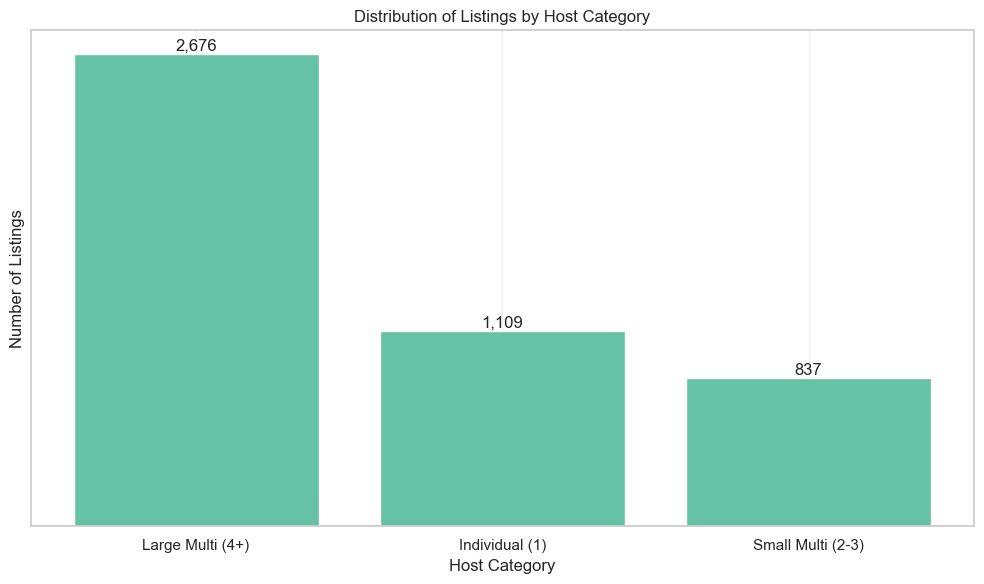

In [10]:
# Bar chart for Host Category distribution
host_category_counts = df["Host_Category"].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(host_category_counts.index, host_category_counts.values)
plt.xlabel('Host Category')
plt.ylabel('Number of Listings')
plt.title('Distribution of Listings by Host Category')
plt.xticks(rotation=0)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom')

ax = plt.gca()
ax.set_yticks([])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
df["host_total_listings_count"].describe()

count   4,387.00
mean       63.60
std       139.29
min         1.00
25%         2.00
50%         5.00
75%        35.00
max     1,038.00
Name: host_total_listings_count, dtype: Float64

In [28]:
df["host_total_listings_count"].mode()

0    1
Name: host_total_listings_count, dtype: Int16

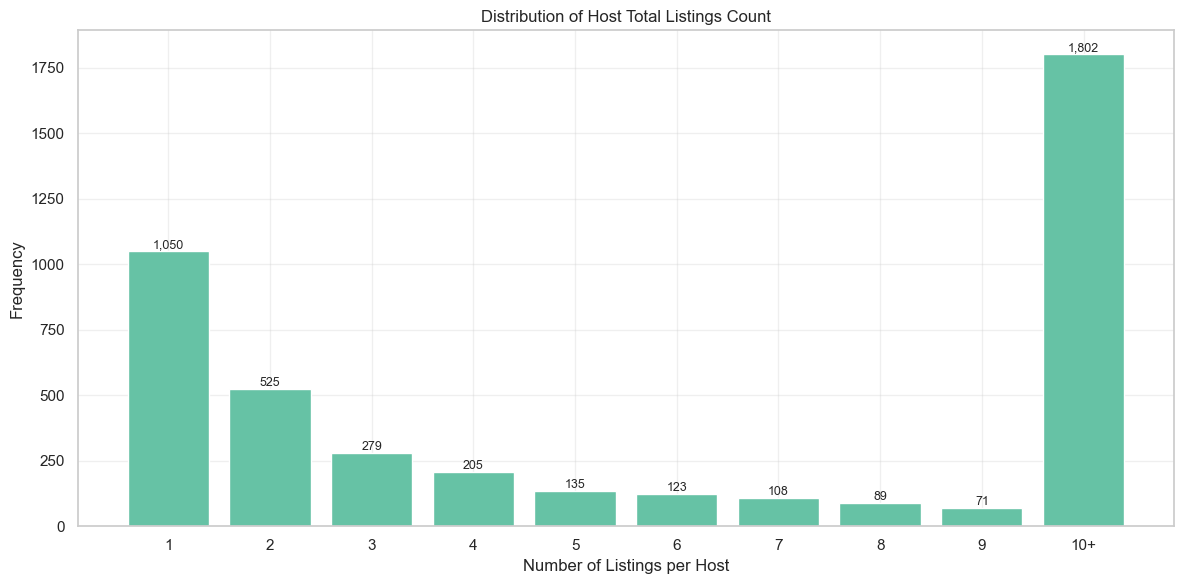

In [29]:
# Create binned histogram for host_total_listings_count
bins = list(range(1, 11)) + [df["host_total_listings_count"].max() + 1]
labels = [str(i) for i in range(1, 10)] + ["10+"]

df["listings_bin"] = pd.cut(df["host_total_listings_count"], bins=bins, labels=labels, right=False)
bin_counts = df["listings_bin"].value_counts().sort_index()

plt.figure(figsize=(12, 6))
bars = plt.bar(bin_counts.index, bin_counts.values)
plt.xlabel('Number of Listings per Host')
plt.ylabel('Frequency')
plt.title('Distribution of Host Total Listings Count')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom', fontsize=9)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Clean up temporary column
df.drop(columns=["listings_bin"], inplace=True)

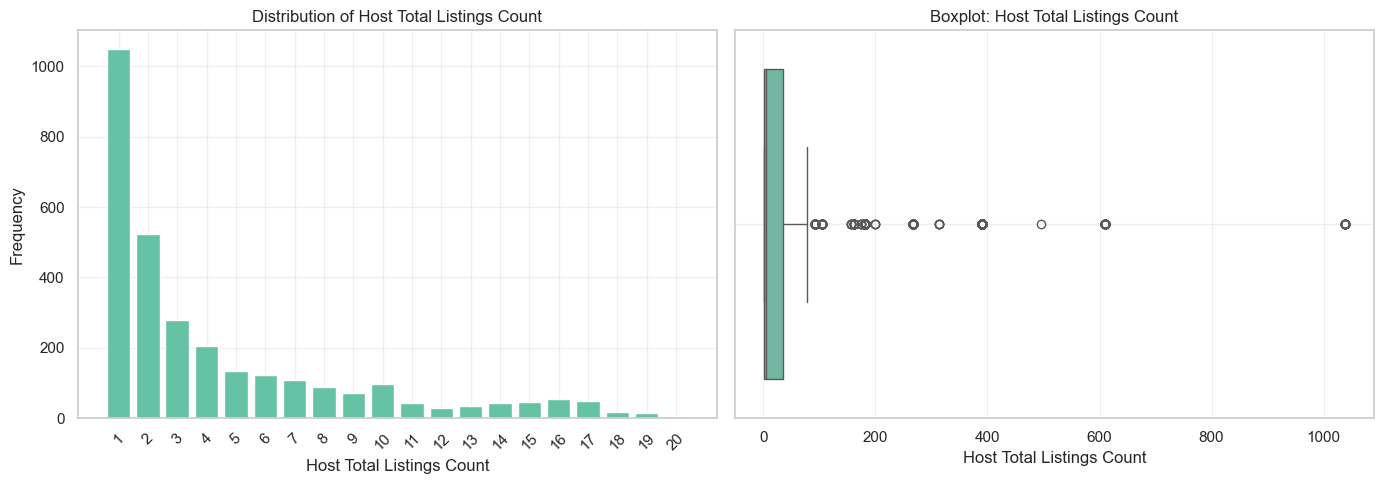

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
listing_counts = df["host_total_listings_count"].value_counts().sort_index().head(20)
axes[0].bar(listing_counts.index.astype(str), listing_counts.values)
axes[0].set_xlabel('Host Total Listings Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Host Total Listings Count')
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(True, alpha=0.3)

# Boxplot
sns.boxplot(x=df["host_total_listings_count"], ax=axes[1])
axes[1].set_xlabel('Host Total Listings Count')
axes[1].set_title('Boxplot: Host Total Listings Count')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Comment:** The distribution of `host_total_listings_count` seems to be highly right-skewed. While most hosts have only 1 listing, there are quite a few extreme outliers with hundreds of listings.

<hr>

### Variables to check against `Host_Category`

In [12]:
df.columns

Index(['id', 'name', 'host_id', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'availability_eoy', 'number_of_reviews_ly',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'instant_bookable',
       'reviews_per_month', 'Host_Categor

In [13]:
variables = [
    "listing_age_years",
    "estimated_revenue_l365d",
    "estimated_occupancy_l365d",
    "review_scores_rating",
    "host_is_superhost"

]

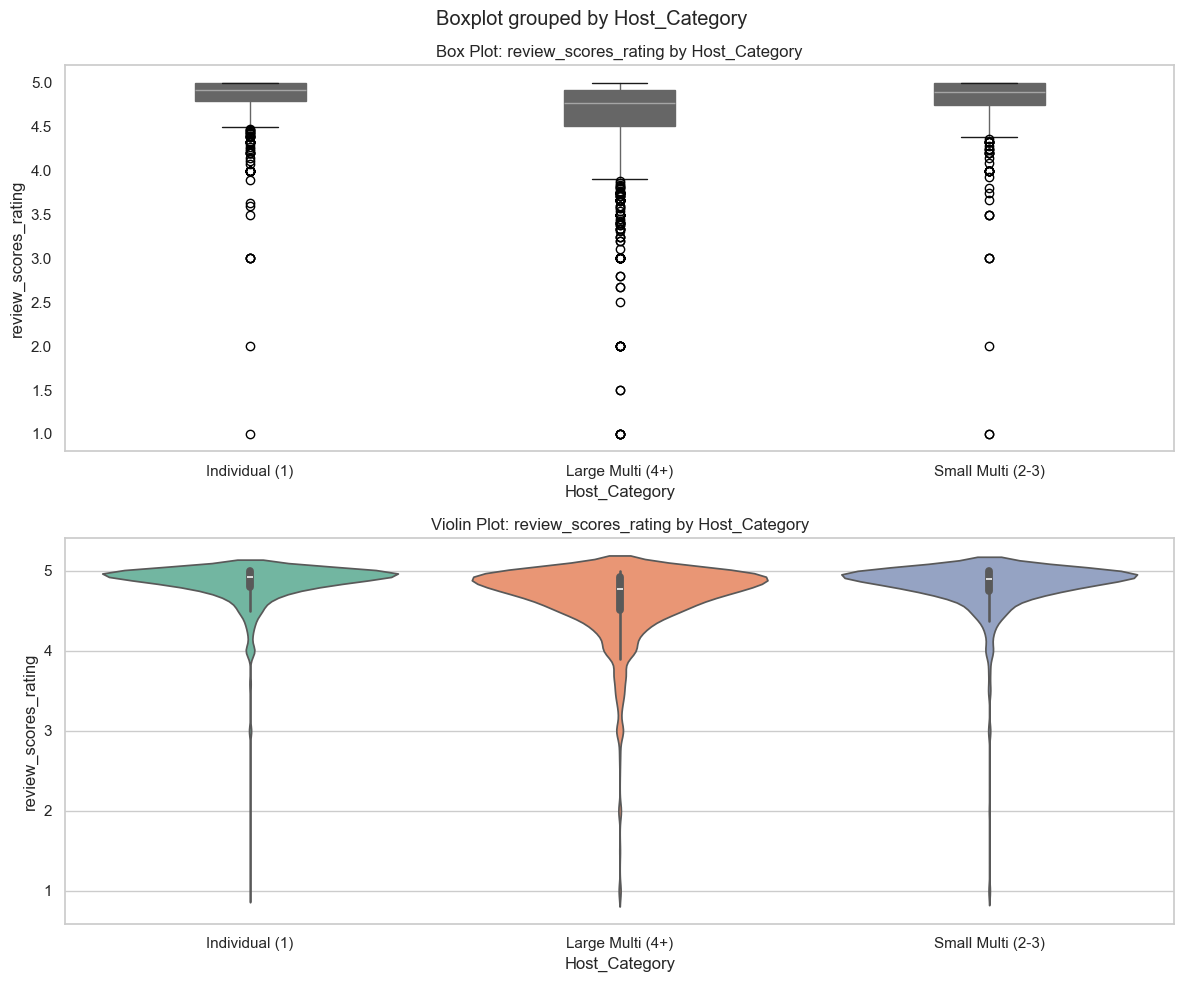

ONE-WAY ANOVA: review_scores_rating by Host_Category

Descriptive Statistics by Group:

  Host_Category = Individual (1):
    N:      998
    Mean:   4.8396
    Median: 4.9200
    Std:    0.2811
    Min:    1.0000
    Max:    5.0000

  Host_Category = Large Multi (4+):
    N:      2348
    Mean:   4.6411
    Median: 4.7700
    Std:    0.4571
    Min:    1.0000
    Max:    5.0000

  Host_Category = Small Multi (2-3):
    N:      765
    Mean:   4.8079
    Median: 4.9000
    Std:    0.3342
    Min:    1.0000
    Max:    5.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      109.1777
  P-value:             0.000000
  Eta-squared (η²):    0.050
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). Host_Category has a significant effect on review_scores_rating. Small effect (Eta-squared (η²) = 0.050).

Assumption Checks:
  Normality (Shapiro-Wilk test):
    Host_Category = Individual (1

In [14]:
analyze_categorical_numerical(df["Host_Category"], df["review_scores_rating"])

In [15]:
for var in variables:
    print(df[var].dtype)

float64
float64
int64
float64
object


DESCRIPTIVE STATISTICS: listing_age_years

Central Tendency:
  Mean:           2.79
  Median:         1.89
  Mode:           0.6543463381245722

Dispersion:
  Std Dev:        2.51
  Variance:       6.32
  Range:          13.06
  IQR:            3.18

Quartiles:
  Min (0%):       0.00
  Q1 (25%):       0.82
  Q2 (50%):       1.89
  Q3 (75%):       4.01
  Max (100%):     13.06

Shape:
  Skewness:       1.068
  Kurtosis:       0.218

Sample Size:
  Valid:          4111
  Missing:        511
  Total:          4622


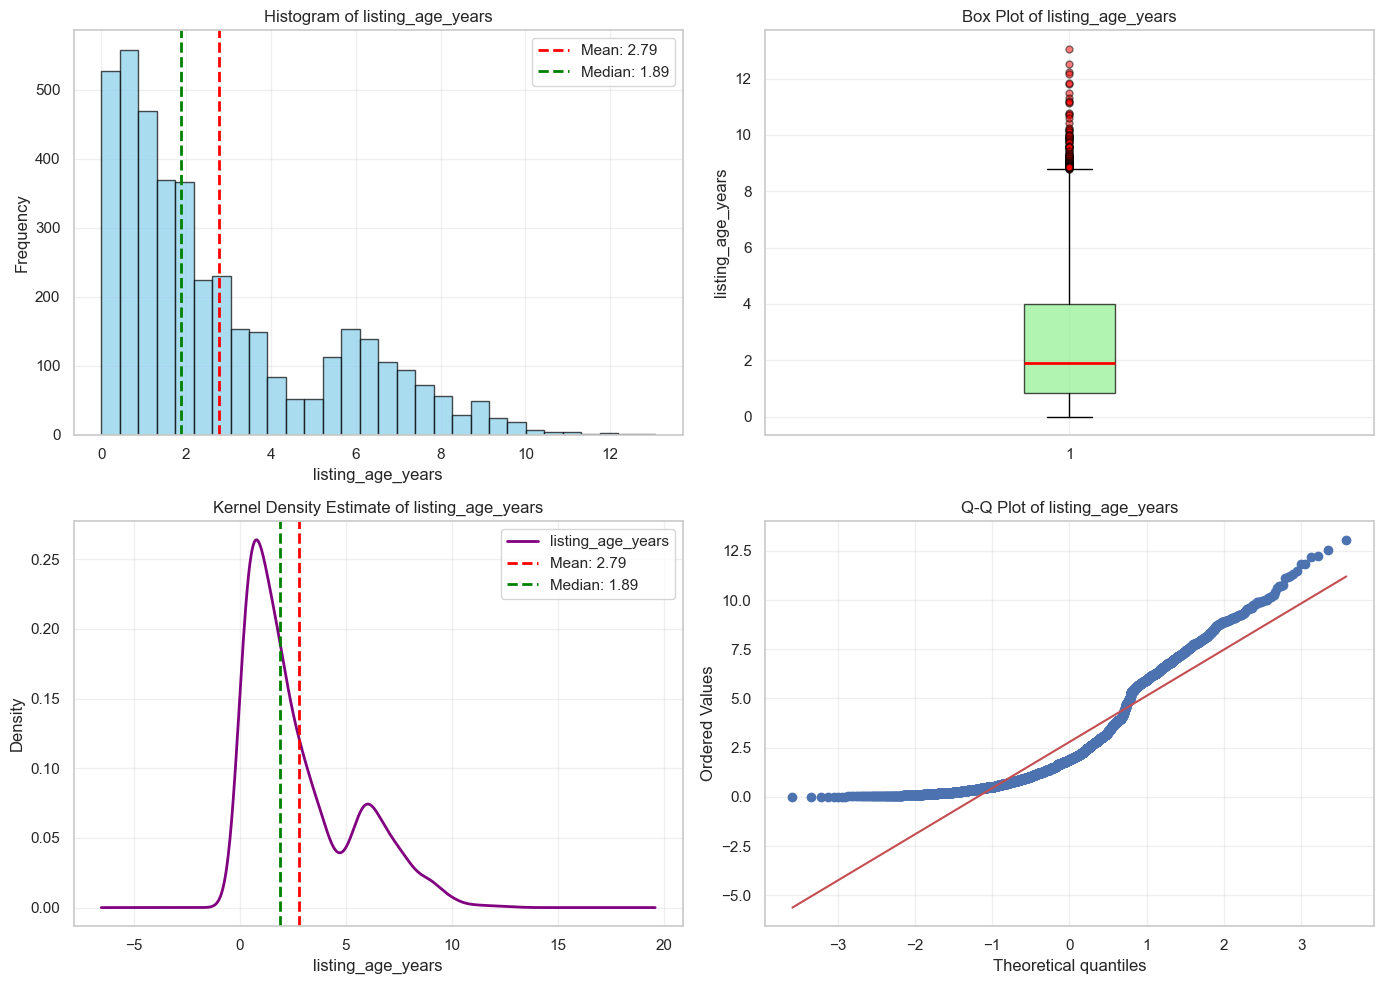

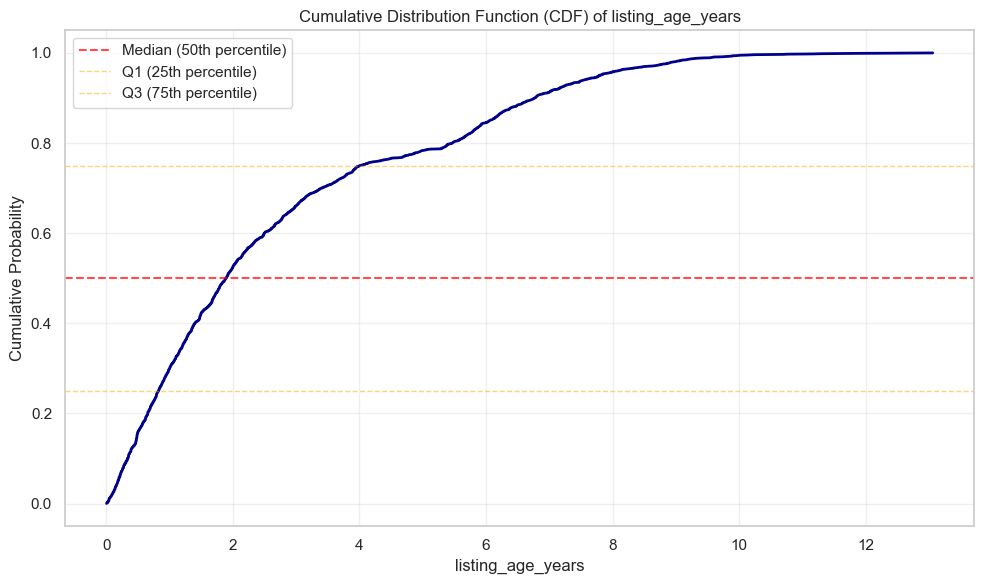

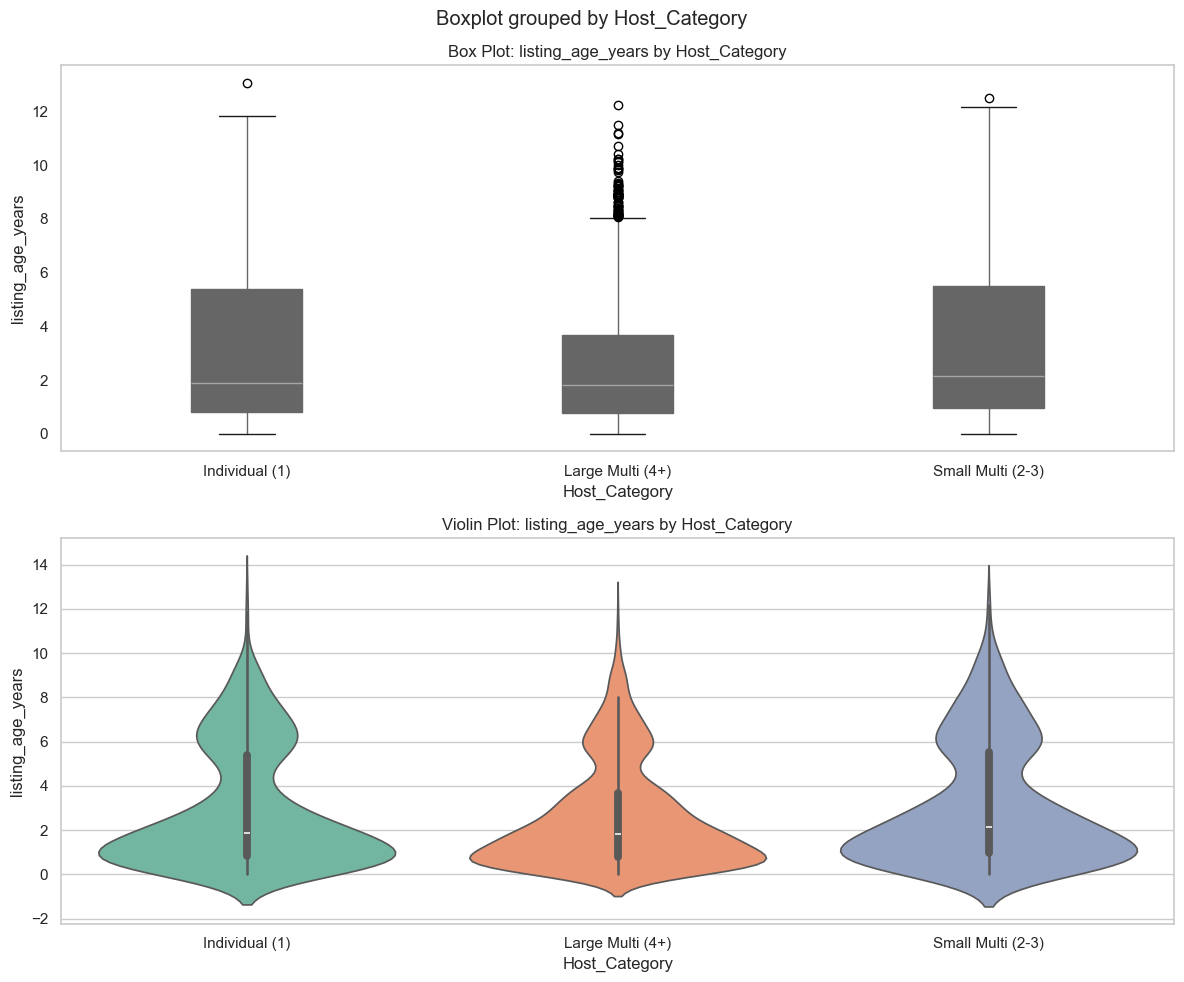

ONE-WAY ANOVA: listing_age_years by Host_Category

Descriptive Statistics by Group:

  Host_Category = Individual (1):
    N:      998
    Mean:   2.9828
    Median: 1.8864
    Std:    2.7017
    Min:    0.0027
    Max:    13.0595

  Host_Category = Large Multi (4+):
    N:      2348
    Mean:   2.5834
    Median: 1.8111
    Std:    2.3242
    Min:    0.0055
    Max:    12.2409

  Host_Category = Small Multi (2-3):
    N:      765
    Mean:   3.1567
    Median: 2.1492
    Std:    2.7492
    Min:    0.0110
    Max:    12.5175

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      19.1659
  P-value:             0.000000
  Eta-squared (η²):    0.009
  Effect size:         Negligible effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). Host_Category has a significant effect on listing_age_years. Negligible effect (Eta-squared (η²) = 0.009).

Assumption Checks:
  Normality (Shapiro-Wilk test):
    Host_Category = Individ

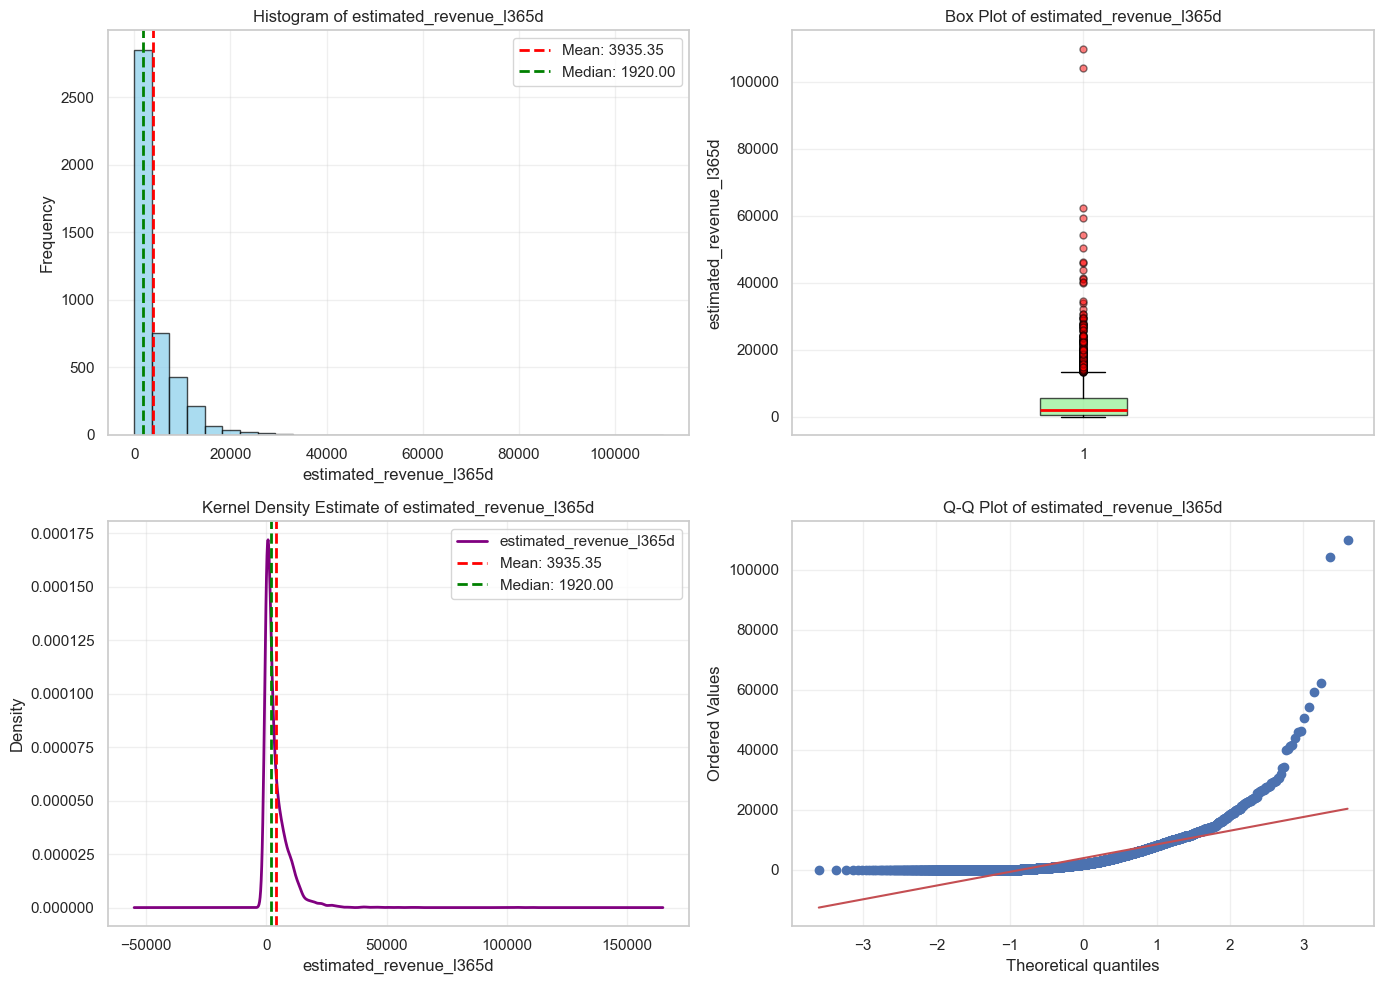

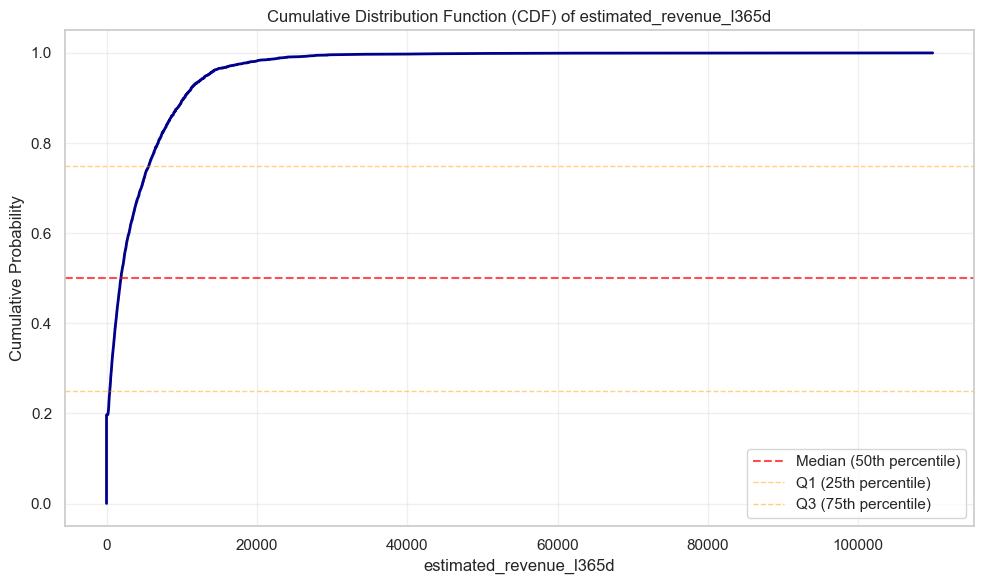

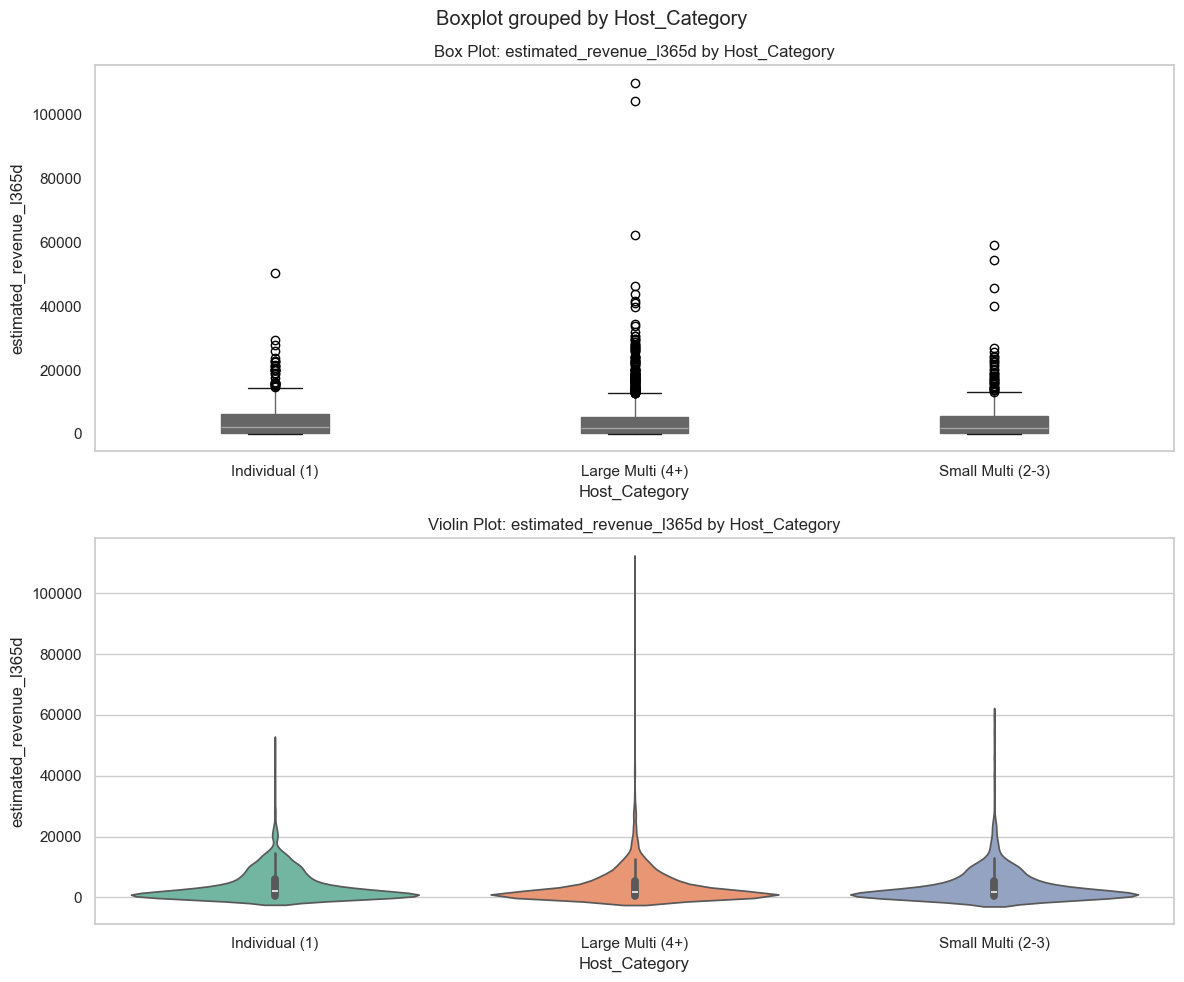

ONE-WAY ANOVA: estimated_revenue_l365d by Host_Category

Descriptive Statistics by Group:

  Host_Category = Individual (1):
    N:      1052
    Mean:   3984.8688
    Median: 2103.0000
    Std:    4887.3390
    Min:    0.0000
    Max:    50430.0000

  Host_Category = Large Multi (4+):
    N:      2555
    Mean:   3931.7750
    Median: 1872.0000
    Std:    6020.4327
    Min:    0.0000
    Max:    109896.0000

  Host_Category = Small Multi (2-3):
    N:      799
    Mean:   3881.5857
    Median: 1776.0000
    Std:    5637.1702
    Min:    0.0000
    Max:    59280.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      0.0758
  P-value:             0.927045
  Eta-squared (η²):    0.000
  Effect size:         Negligible effect
  Significant at α=0.05: NO

Interpretation:
  NO significant difference (p=0.927045). Host_Category does not significantly affect estimated_revenue_l365d.

Assumption Checks:
  Normality (Shapiro-Wilk test):
    Host_Category = Individua

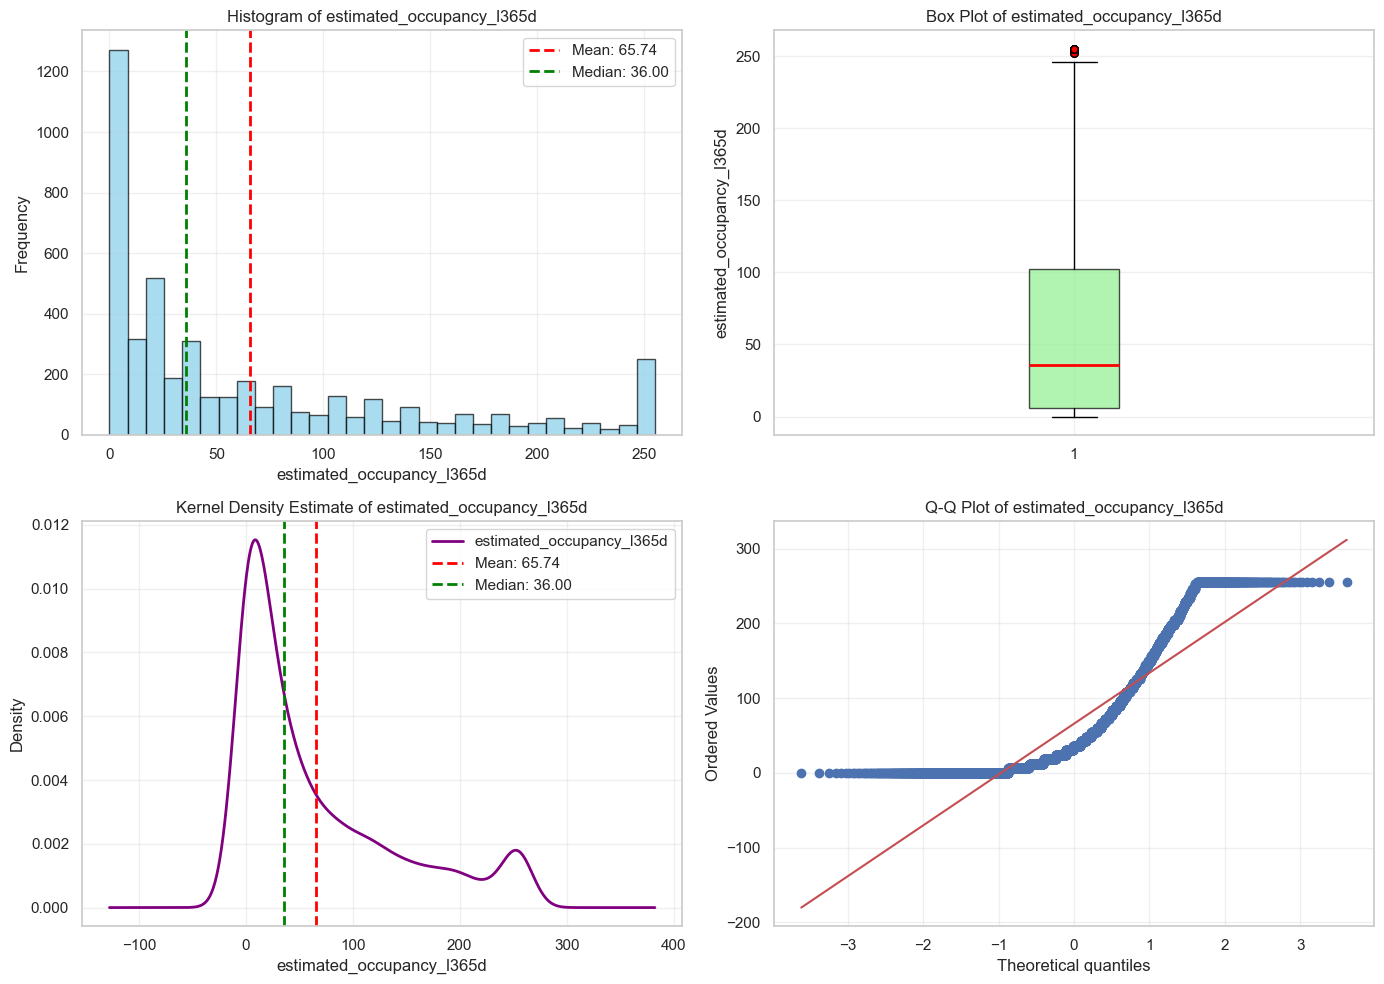

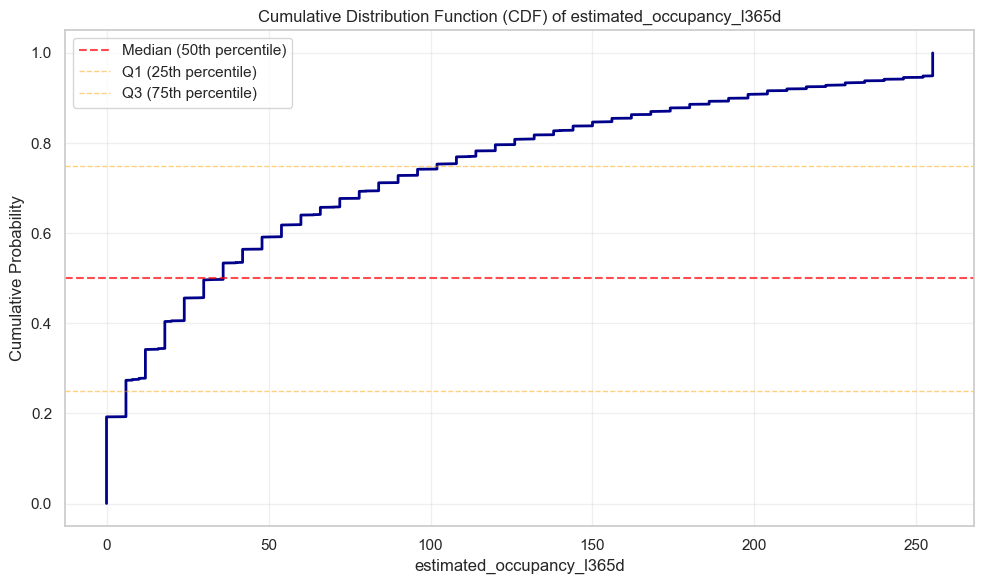

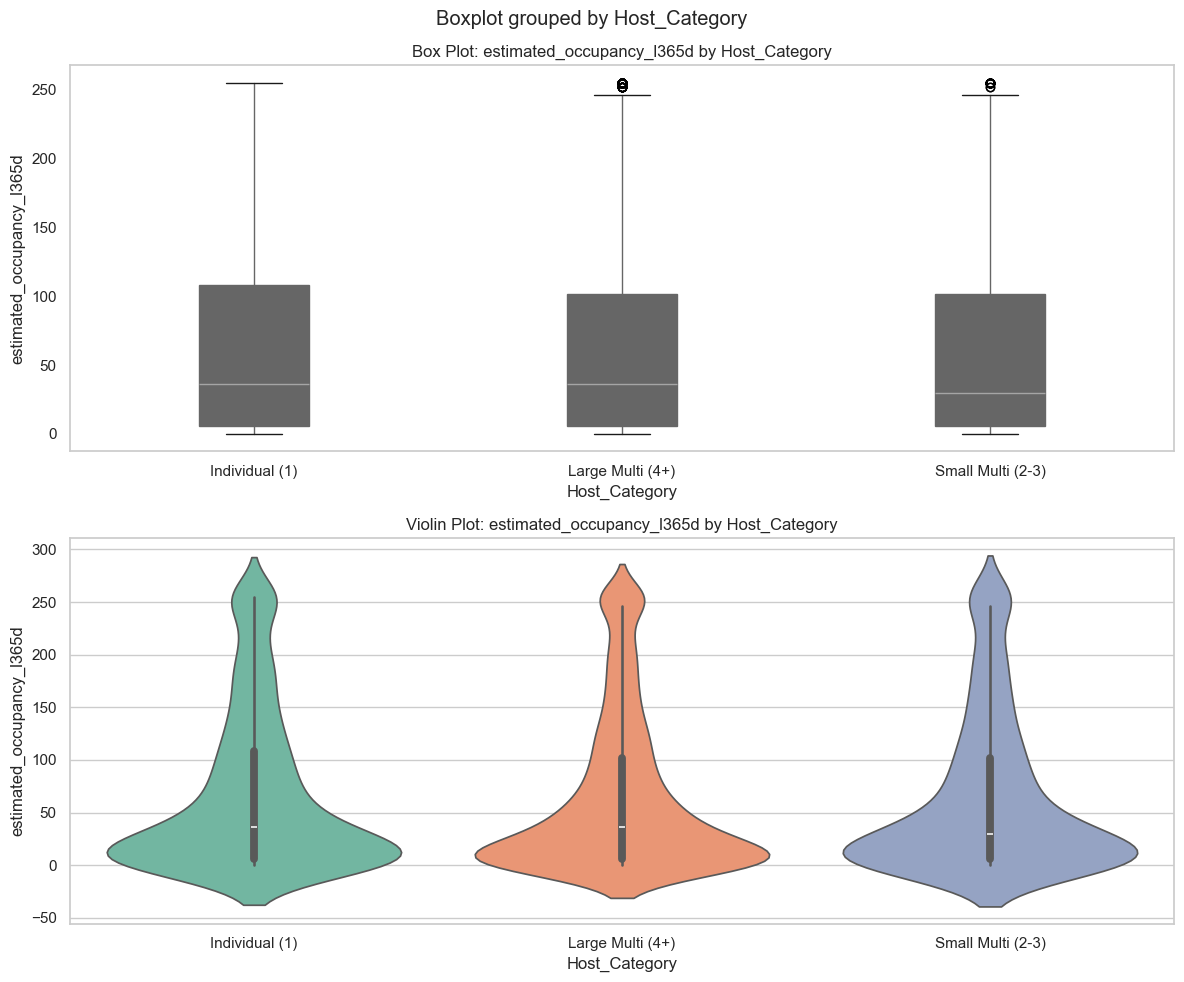

ONE-WAY ANOVA: estimated_occupancy_l365d by Host_Category

Descriptive Statistics by Group:

  Host_Category = Individual (1):
    N:      1109
    Mean:   67.9243
    Median: 36.0000
    Std:    76.5103
    Min:    0.0000
    Max:    255.0000

  Host_Category = Large Multi (4+):
    N:      2676
    Mean:   65.0437
    Median: 36.0000
    Std:    75.3698
    Min:    0.0000
    Max:    255.0000

  Host_Category = Small Multi (2-3):
    N:      837
    Mean:   65.0705
    Median: 30.0000
    Std:    75.3506
    Min:    0.0000
    Max:    255.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      0.6085
  P-value:             0.544196
  Eta-squared (η²):    0.000
  Effect size:         Negligible effect
  Significant at α=0.05: NO

Interpretation:
  NO significant difference (p=0.544196). Host_Category does not significantly affect estimated_occupancy_l365d.

Assumption Checks:
  Normality (Shapiro-Wilk test):
    Host_Category = Individual (1): p=0.0000 (Non-

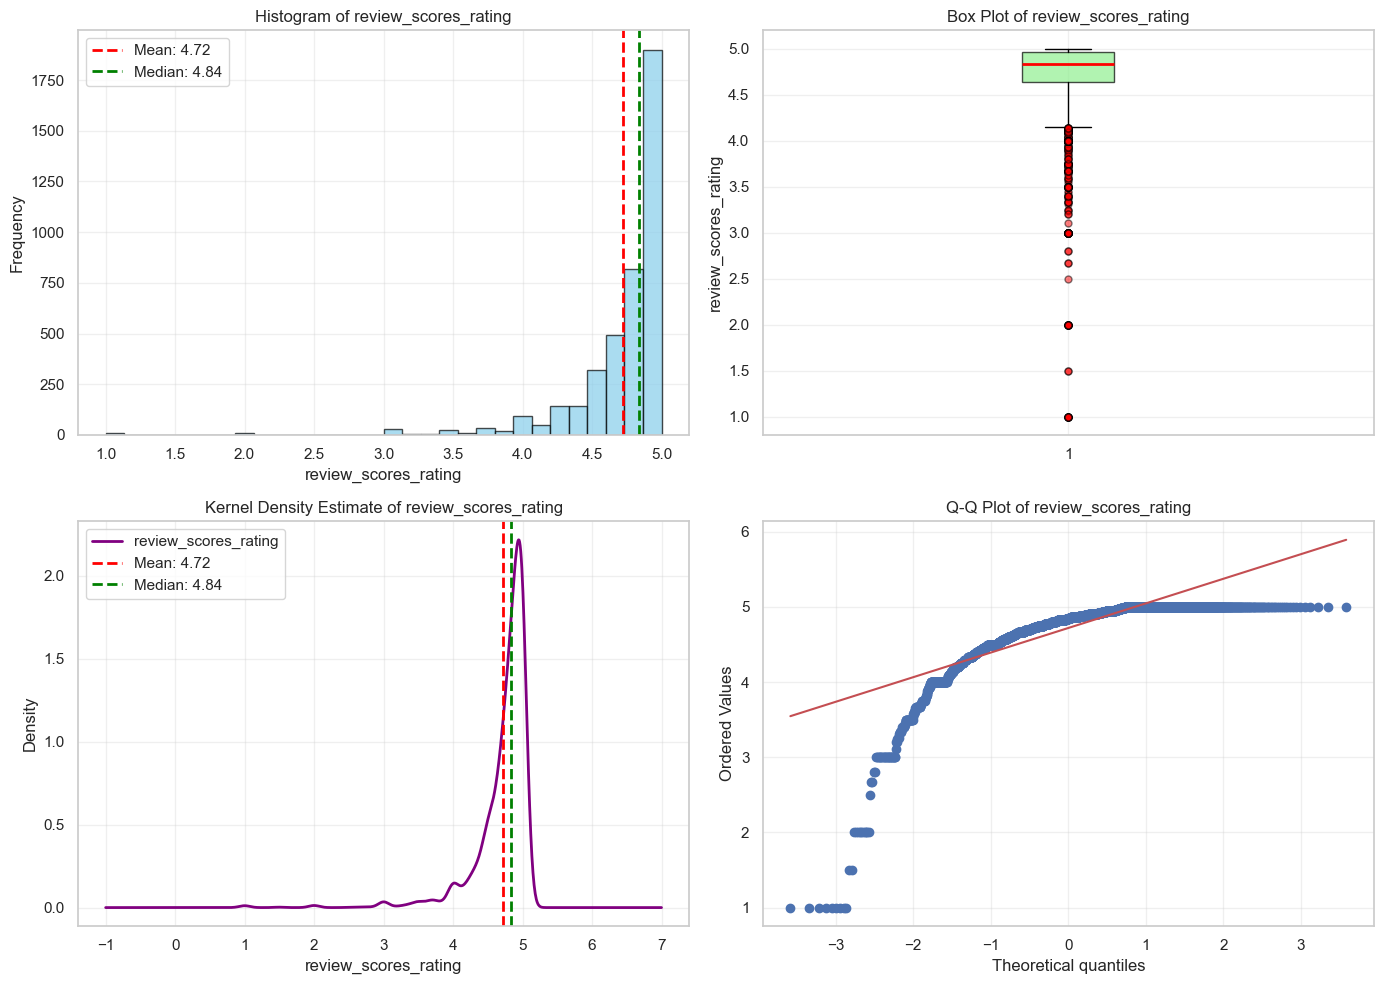

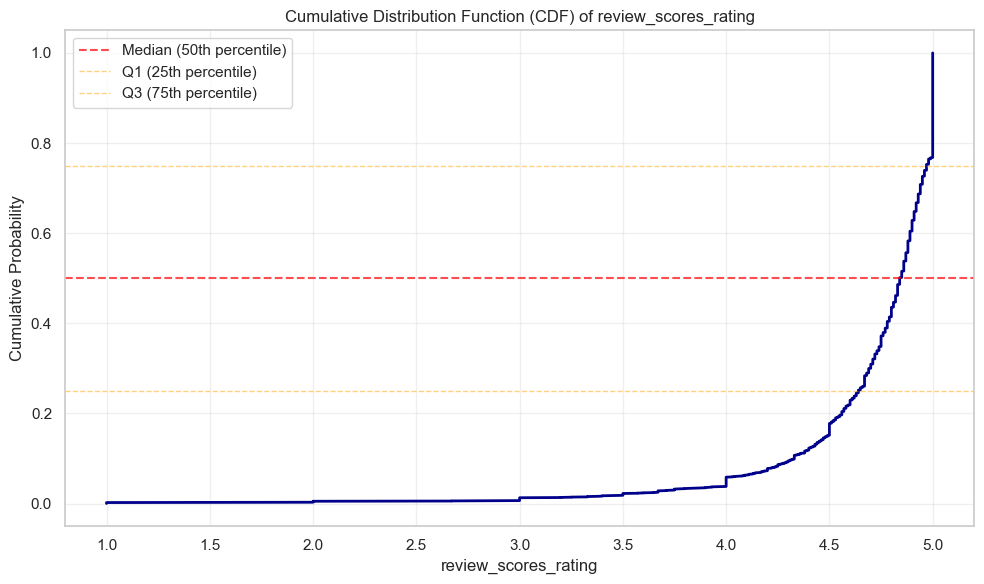

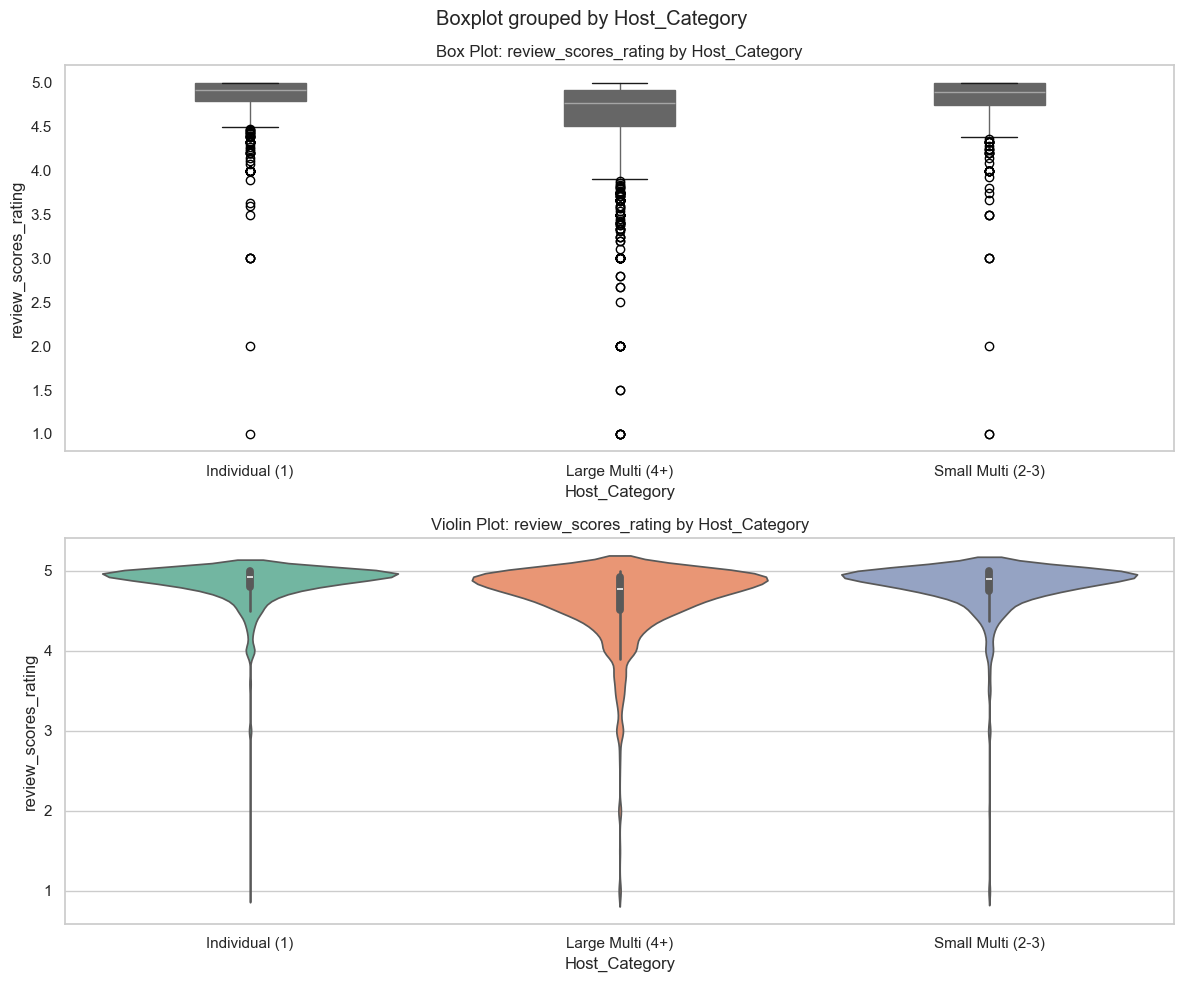

ONE-WAY ANOVA: review_scores_rating by Host_Category

Descriptive Statistics by Group:

  Host_Category = Individual (1):
    N:      998
    Mean:   4.8396
    Median: 4.9200
    Std:    0.2811
    Min:    1.0000
    Max:    5.0000

  Host_Category = Large Multi (4+):
    N:      2348
    Mean:   4.6411
    Median: 4.7700
    Std:    0.4571
    Min:    1.0000
    Max:    5.0000

  Host_Category = Small Multi (2-3):
    N:      765
    Mean:   4.8079
    Median: 4.9000
    Std:    0.3342
    Min:    1.0000
    Max:    5.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      109.1777
  P-value:             0.000000
  Eta-squared (η²):    0.050
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). Host_Category has a significant effect on review_scores_rating. Small effect (Eta-squared (η²) = 0.050).

Assumption Checks:
  Normality (Shapiro-Wilk test):
    Host_Category = Individual (1

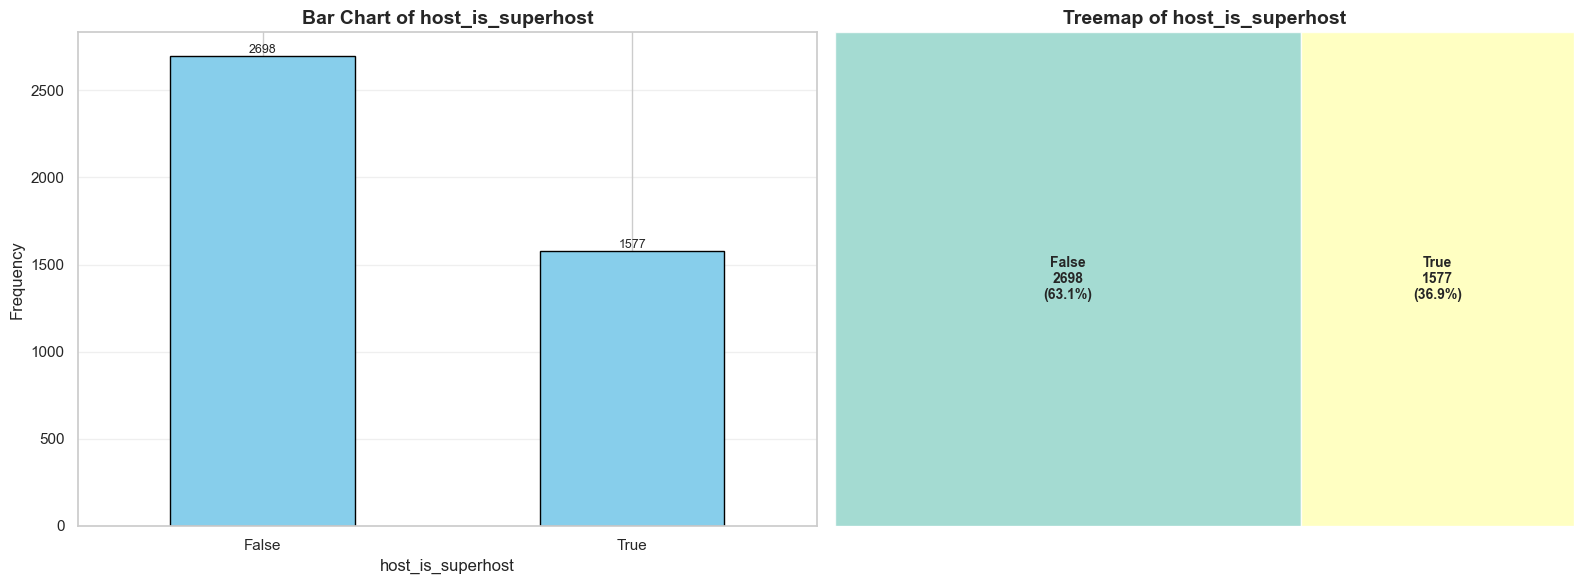

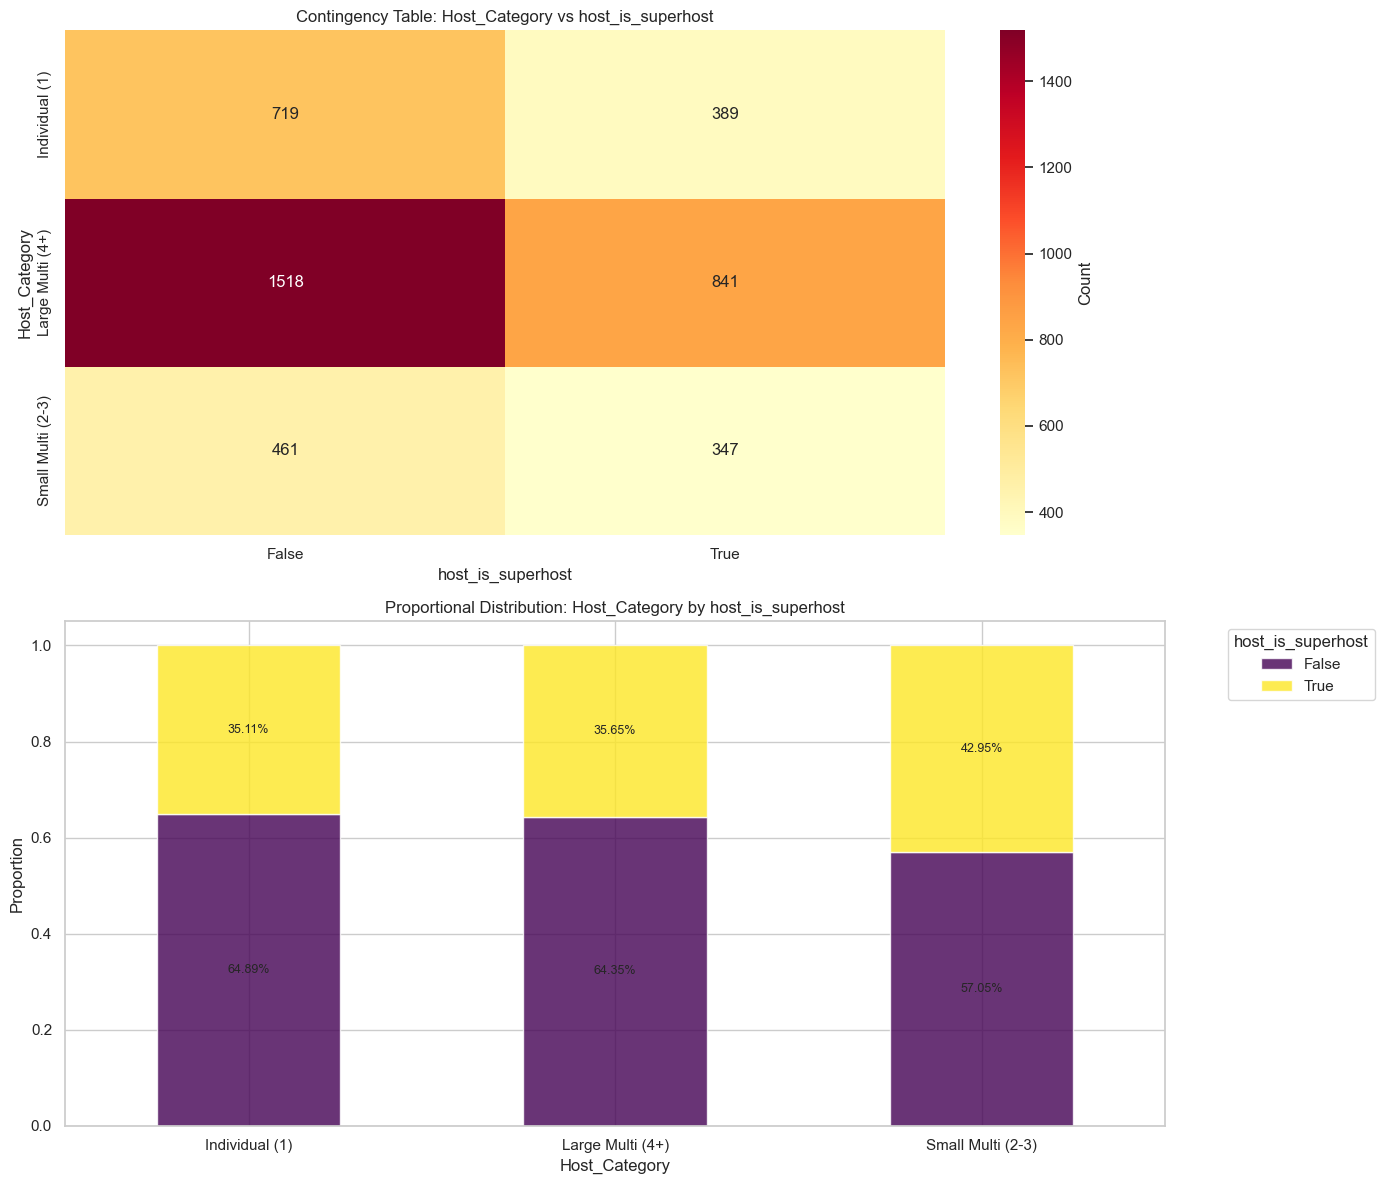

CHI-SQUARE TEST OF INDEPENDENCE: Host_Category vs host_is_superhost

Contingency Table:
host_is_superhost  False  True 
Host_Category                  
Individual (1)       719    389
Large Multi (4+)    1518    841
Small Multi (2-3)    461    347

Test Statistics:
  Chi-square statistic: 15.7938
  Degrees of freedom:   2
  P-value:              0.000372
  Cramér's V:           0.061
  Effect size:          Negligible association
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT association detected (p=0.000372). Host_Category and host_is_superhost are related. Negligible association (Cramér's V = 0.061).


In [16]:
for var in variables:
    
    if pd.api.types.is_numeric_dtype(df[var]):
        
        analyze_numeric_variable(df[var])
        analyze_categorical_numerical(df["Host_Category"], df[var])

    else:
        
        analyze_categorical_variable(df[var])
        analyze_categorical_categorical(df["Host_Category"], df[var])

#### Main Findings

### 1 - Estimated revenue

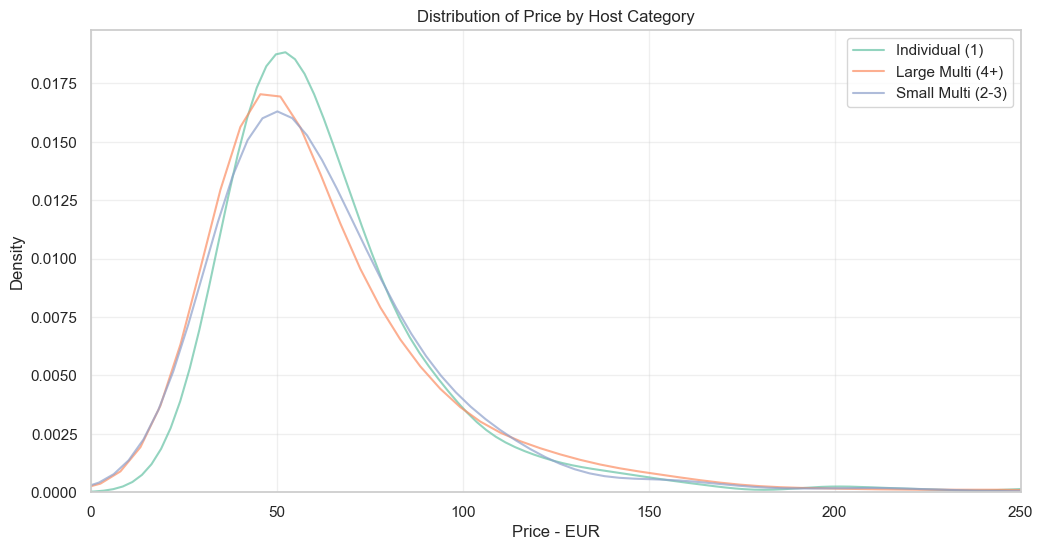

In [20]:
plt.figure(figsize=(12, 6))
for category in df["Host_Category"].unique():
    data = df[df['Host_Category'] == category]['price'].dropna()
    sns.kdeplot(data=data, label=category, alpha=0.7)

plt.xlabel('Price - EUR')
plt.ylabel('Density')
plt.title('Distribution of Price by Host Category')
plt.xlim(0, 250)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Document the price distribution in your technical notebook with a note that "pricing strategies are consistent across host types, confirming revenue differences reflect operational performance rather than pricing positioning.

In [12]:
df["estimated_revenue_l365d"].describe()

count      4173.000000
mean       3998.912054
std        5747.099720
min           0.000000
25%         468.000000
50%        1980.000000
75%        5712.000000
max      109896.000000
Name: estimated_revenue_l365d, dtype: float64

est revenue
* Average estimated revenue seems to be a little larger for individual hosts followed closely by multi hosts.
* Individuals and multi hosts show similar distribution until 3000 euros, then 4+ shows bigger density in the 3000 to 7000 range and lastly the indiual listing hosts show bigger density in the 7000 to 15000 range
* 2-3 category isalways below each of those two although close 

Est occupancy
* nothing importand to note here, all categories show the same characteristics

### 3 - Reviews per month

In [25]:
df["reviews_per_month"].describe()

count    3950.000000
mean        1.461003
std         1.357813
min         0.010000
25%         0.460000
50%         1.050000
75%         2.040000
max        15.000000
Name: reviews_per_month, dtype: float64

In [54]:
df_null = df.loc[df["review_scores_rating"].isnull()]

In [56]:
df_null.host_is_superhost.value_counts()

host_is_superhost
False    395
True      96
Name: count, dtype: int64

In [57]:
df_null.loc[df_null["host_is_superhost"] == True]

,id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,...,instant_bookable,reviews_per_month,Host_Category,distance_to_center_km,distance_cat,price_cat,first_review_date,last_review_date,listing_age_years,market_maturity
1598,PROP_B7668F,Co - Enti - En #0029,HOST_6E65BD,2022-08-13,"Thessaloniki, Greece",within an hour,89%,0.95,True,6,...,True,NaN,Large Multi (4+),1.11,Inner City (1-3km),High (80-120€),NaT,NaT,NaN,NaN
1726,PROP_343263,AR - Enti - En #0777,HOST_B08C79,2021-06-01,"Thessaloniki, Greece",within an hour,100%,1.00,True,3,...,True,NaN,Small Multi (2-3),0.92,Downtown (<1km),Low (40-60€),NaT,NaT,NaN,NaN
1785,PROP_098CD0,Ca - Eart - En #0001,HOST_9599F4,2022-12-10,"Thessaloniki, Greece",within an hour,100%,1.00,True,7,...,True,NaN,Large Multi (4+),2.90,Inner City (1-3km),High (80-120€),NaT,NaT,NaN,NaN
1955,PROP_3A4C62,Po - Enti - En #1061,HOST_CB0F05,2020-10-16,"Thessaloniki, Greece",within an hour,100%,1.00,True,42,...,True,NaN,Large Multi (4+),0.87,Downtown (<1km),High (80-120€),NaT,NaT,NaN,NaN
1957,PROP_3D2956,Po - Enti - En #1063,HOST_CB0F05,2020-10-16,"Thessaloniki, Greece",within an hour,100%,1.00,True,42,...,True,NaN,Large Multi (4+),0.98,Downtown (<1km),Medium (60-80€),NaT,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4609,PROP_1E382A,vi - Enti - En #2918,HOST_583EAB,2016-11-11,"Thessaloniki, Greece",within an hour,100%,1.00,True,67,...,True,NaN,Large Multi (4+),3.94,Neighborhoods (3-6km),Medium (60-80€),NaT,NaT,NaN,NaN
4610,PROP_74CC71,vi - Enti - En #2919,HOST_583EAB,2016-11-11,"Thessaloniki, Greece",within an hour,100%,1.00,True,67,...,True,NaN,Large Multi (4+),3.92,Neighborhoods (3-6km),Medium (60-80€),NaT,NaT,NaN,NaN
4615,PROP_FFA323,B& - Enti - En #2924,HOST_CD0679,2023-02-25,"Thessaloniki, Greece",within an hour,100%,0.97,True,2,...,False,NaN,Small Multi (2-3),1.88,Inner City (1-3km),Low (40-60€),NaT,NaT,NaN,NaN
4617,PROP_29BBD0,Wh - Enti - En #2926,HOST_D51EB6,2012-03-20,"Thessaloniki, Greece",within an hour,100%,1.00,True,104,...,True,NaN,Large Multi (4+),1.94,Inner City (1-3km),Medium (60-80€),NaT,NaT,NaN,NaN


listings seem to be dead, but there are many superhosts allthough the listing seems to have 0 reviews

### **what to do with all these nulls?**

In [39]:
for category in df["Host_Category"].unique():
    print(f"Host Category: {category}")
    mean = df.loc[df['Host_Category'] == category]["review_scores_rating"].dropna().mean()
    print(f"  Average Review Scores Rating: {mean:.2f} stars")

Host Category: Individual (1)
  Average Review Scores Rating: 4.84 stars
Host Category: Large Multi (4+)
  Average Review Scores Rating: 4.64 stars
Host Category: Small Multi (2-3)
  Average Review Scores Rating: 4.81 stars


### 5 - Acceptance rate

In [43]:
df["host_acceptance_rate"].describe()

count   4,142.00
mean        0.94
std         0.17
min         0.00
25%         0.99
50%         1.00
75%         1.00
max         1.00
Name: host_acceptance_rate, dtype: float64

In [37]:
df.loc[df["host_acceptance_rate"]==0]

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month,host_category
0,218831,Sea-life apartment,137588,2010-06-03,"Thessalonika, Greece",0.0,False,2,False,"Kalamaria Municipality, Greece",...,5.00,4.00,5.00,5.0,5.00,5.00,00000049330,False,0.02,Small Multi (2-3)
13,2639807,Apollon - Central apartment,13516901,2014-03-25,"Thessaloniki, Greece",0.0,False,1,True,NaN,...,4.92,4.88,4.90,4.9,4.65,4.72,00000161920,False,0.79,Individual (1)
32,6408408,EVANGELIA: Only Good News Here...,33423743,2015-05-15,"Thessaloniki, Greece",0.0,False,3,True,"Thessaloníki, Greece",...,4.85,4.74,4.89,5.0,4.88,4.80,00000378638,False,0.54,Small Multi (2-3)
77,11651643,City center elegant loft,36326447,2015-06-21,"Thessaloniki, Greece",0.0,False,2,True,"Thessaloniki, Greece",...,5.00,4.97,5.00,5.0,5.00,4.95,00000209181,False,0.62,Small Multi (2-3)
100,12839242,Million dollars view,70104544,2016-05-03,"Thessaloniki, Greece",0.0,False,1,True,"Thessaloniki, Makedonia Thraki, Greece",...,4.88,4.71,4.96,4.9,4.77,4.93,00000144789,False,1.20,Individual (1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4127,1378064487237445599,Άνετο διαμέρισμα με ένα δωμάτιο.,318973561,2019-12-19,"Thessaloniki, Greece",0.0,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003251136,False,NaN,Individual (1)
4134,1379728058017266732,Δωμάτιο Θεσσαλονίκη,682925599,2025-03-07,None,0.0,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14919365701,False,NaN,Individual (1)
4319,1420470401996555460,Four Suns Loft,14852638,2014-04-28,"Skopje, North Macedonia",0.0,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003312231,False,NaN,Individual (1)
4346,1425082103671191566,il Panorama,563383717,2024-02-22,None,0.0,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003207999,False,NaN,Individual (1)


In [42]:
df.loc[df["host_acceptance_rate"]==0]

,id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,...,instant_bookable,reviews_per_month,Host_Category,distance_to_center_km,distance_cat,price_cat,first_review_date,last_review_date,listing_age_years,market_maturity
12,PROP_AF9279,Ap - Enti - En #0012,HOST_79F337,2014-03-25,"Thessaloniki, Greece",None,None,0.00,False,1,...,False,0.79,Individual (1),1.21,Inner City (1-3km),High (80-120€),2014-05-03,2022-04-17,11.14,Established (>8yr)
31,PROP_2C30B9,EV - Priv - Pr #0004,HOST_90EF61,2015-05-15,"Thessaloniki, Greece",None,None,0.00,False,3,...,False,0.54,Small Multi (2-3),1.18,Inner City (1-3km),Very Low (<40€),2015-06-28,2022-10-04,9.99,Established (>8yr)
75,PROP_066AC7,Ci - Enti - En #0047,HOST_38AA69,2015-06-21,"Thessaloniki, Greece",within a day,100%,0.00,False,2,...,False,0.62,Small Multi (2-3),0.60,Downtown (<1km),Very High (>120€),2017-08-19,2019-07-25,7.85,Mature (4-8yr)
97,PROP_E70234,Mi - Enti - En #0060,HOST_8E7810,2016-05-03,"Thessaloniki, Greece",within an hour,100%,0.00,False,1,...,False,1.20,Individual (1),1.42,Inner City (1-3km),Very Low (<40€),2016-05-31,2021-10-26,9.07,Established (>8yr)
103,PROP_CE61E8,Pe - Enti - En #0065,HOST_9AF91C,2016-06-01,"Thessaloniki, Greece",None,None,0.00,False,2,...,False,2.80,Small Multi (2-3),2.22,Inner City (1-3km),Very Low (<40€),2016-06-26,2022-07-30,8.99,Established (>8yr)
239,PROP_757E33,Pr - Enti - En #0065,HOST_A53E3E,2017-09-02,"Thessaloniki, Greece",a few days or more,13%,0.00,False,1,...,False,0.44,Individual (1),3.64,Neighborhoods (3-6km),Very Low (<40€),2022-07-03,2023-07-31,2.98,Growing (2-4yr)
248,PROP_684EBD,Th - Priv - Pr #0004,HOST_CA4A7F,2011-10-02,"Thessaloniki, Greece",None,None,0.00,False,1,...,False,0.28,Individual (1),1.34,Inner City (1-3km),Very Low (<40€),2017-10-05,2024-02-05,7.72,Mature (4-8yr)
352,PROP_C2A918,Λε - Enti - En #0260,HOST_204AB9,2018-04-08,Greece,None,None,0.00,False,1,...,False,0.02,Individual (1),6.44,Suburban (>6km),Very High (>120€),2018-04-29,2019-10-28,7.15,Mature (4-8yr)
365,PROP_EBCF93,Ar - Enti - En #0270,HOST_F391A7,2017-02-04,"Thessaloniki, Greece",None,None,0.00,False,2,...,False,0.01,Small Multi (2-3),0.60,Downtown (<1km),High (80-120€),2019-09-08,2019-09-08,5.79,Mature (4-8yr)
435,PROP_DFBB01,El - Enti - En #0324,HOST_EBF9B4,2018-08-20,"Thessaloniki, Greece",None,None,0.00,False,1,...,False,0.06,Individual (1),3.59,Neighborhoods (3-6km),Very Low (<40€),2018-11-14,2019-07-28,6.61,Mature (4-8yr)


In [45]:
zero_acceptance = df[df['host_acceptance_rate'] == 0]

print("Average availability:", 
      zero_acceptance['availability_365'].mean())
print("Average revenue estimates:", 
      zero_acceptance['estimated_revenue_l365d'].mean())

Average availability: 229.94736842105263
Average revenue estimates: 10.714285714285714


In [46]:
inactive_listings = df.loc[(df["host_acceptance_rate"]==0) & 
                           (df["estimated_occupancy_l365d"]==0) & 
                           (df["number_of_reviews_ly"]==0)]
inactive_listings

,id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,...,instant_bookable,reviews_per_month,Host_Category,distance_to_center_km,distance_cat,price_cat,first_review_date,last_review_date,listing_age_years,market_maturity
12,PROP_AF9279,Ap - Enti - En #0012,HOST_79F337,2014-03-25,"Thessaloniki, Greece",None,None,0.00,False,1,...,False,0.79,Individual (1),1.21,Inner City (1-3km),High (80-120€),2014-05-03,2022-04-17,11.14,Established (>8yr)
31,PROP_2C30B9,EV - Priv - Pr #0004,HOST_90EF61,2015-05-15,"Thessaloniki, Greece",None,None,0.00,False,3,...,False,0.54,Small Multi (2-3),1.18,Inner City (1-3km),Very Low (<40€),2015-06-28,2022-10-04,9.99,Established (>8yr)
75,PROP_066AC7,Ci - Enti - En #0047,HOST_38AA69,2015-06-21,"Thessaloniki, Greece",within a day,100%,0.00,False,2,...,False,0.62,Small Multi (2-3),0.60,Downtown (<1km),Very High (>120€),2017-08-19,2019-07-25,7.85,Mature (4-8yr)
97,PROP_E70234,Mi - Enti - En #0060,HOST_8E7810,2016-05-03,"Thessaloniki, Greece",within an hour,100%,0.00,False,1,...,False,1.20,Individual (1),1.42,Inner City (1-3km),Very Low (<40€),2016-05-31,2021-10-26,9.07,Established (>8yr)
103,PROP_CE61E8,Pe - Enti - En #0065,HOST_9AF91C,2016-06-01,"Thessaloniki, Greece",None,None,0.00,False,2,...,False,2.80,Small Multi (2-3),2.22,Inner City (1-3km),Very Low (<40€),2016-06-26,2022-07-30,8.99,Established (>8yr)
239,PROP_757E33,Pr - Enti - En #0065,HOST_A53E3E,2017-09-02,"Thessaloniki, Greece",a few days or more,13%,0.00,False,1,...,False,0.44,Individual (1),3.64,Neighborhoods (3-6km),Very Low (<40€),2022-07-03,2023-07-31,2.98,Growing (2-4yr)
352,PROP_C2A918,Λε - Enti - En #0260,HOST_204AB9,2018-04-08,Greece,None,None,0.00,False,1,...,False,0.02,Individual (1),6.44,Suburban (>6km),Very High (>120€),2018-04-29,2019-10-28,7.15,Mature (4-8yr)
365,PROP_EBCF93,Ar - Enti - En #0270,HOST_F391A7,2017-02-04,"Thessaloniki, Greece",None,None,0.00,False,2,...,False,0.01,Small Multi (2-3),0.60,Downtown (<1km),High (80-120€),2019-09-08,2019-09-08,5.79,Mature (4-8yr)
435,PROP_DFBB01,El - Enti - En #0324,HOST_EBF9B4,2018-08-20,"Thessaloniki, Greece",None,None,0.00,False,1,...,False,0.06,Individual (1),3.59,Neighborhoods (3-6km),Very Low (<40€),2018-11-14,2019-07-28,6.61,Mature (4-8yr)
496,PROP_7A6B30,Di - Enti - En #0012,HOST_EBADE5,2017-07-11,"Thessaloniki, Greece",within a day,50%,0.00,False,6,...,False,0.04,Large Multi (4+),3.69,Neighborhoods (3-6km),Low (40-60€),2018-11-30,2023-11-30,6.57,Mature (4-8yr)


the above listings seem to be somehow inactive and will be removed for the analysis of the current variable

In [48]:
df_active = df.drop(index=inactive_listings.index)
for category in df_active["Host_Category"].unique():
    print(f"Host Category: {category}")
    mean = df_active.loc[df_active['Host_Category'] == category]["host_acceptance_rate"].mean()
    print(f"  Average Host Acceptance Rate: {mean:.2f}")

Host Category: Individual (1)
  Average Host Acceptance Rate: 0.94
Host Category: Large Multi (4+)
  Average Host Acceptance Rate: 0.97
Host Category: Small Multi (2-3)
  Average Host Acceptance Rate: 0.93


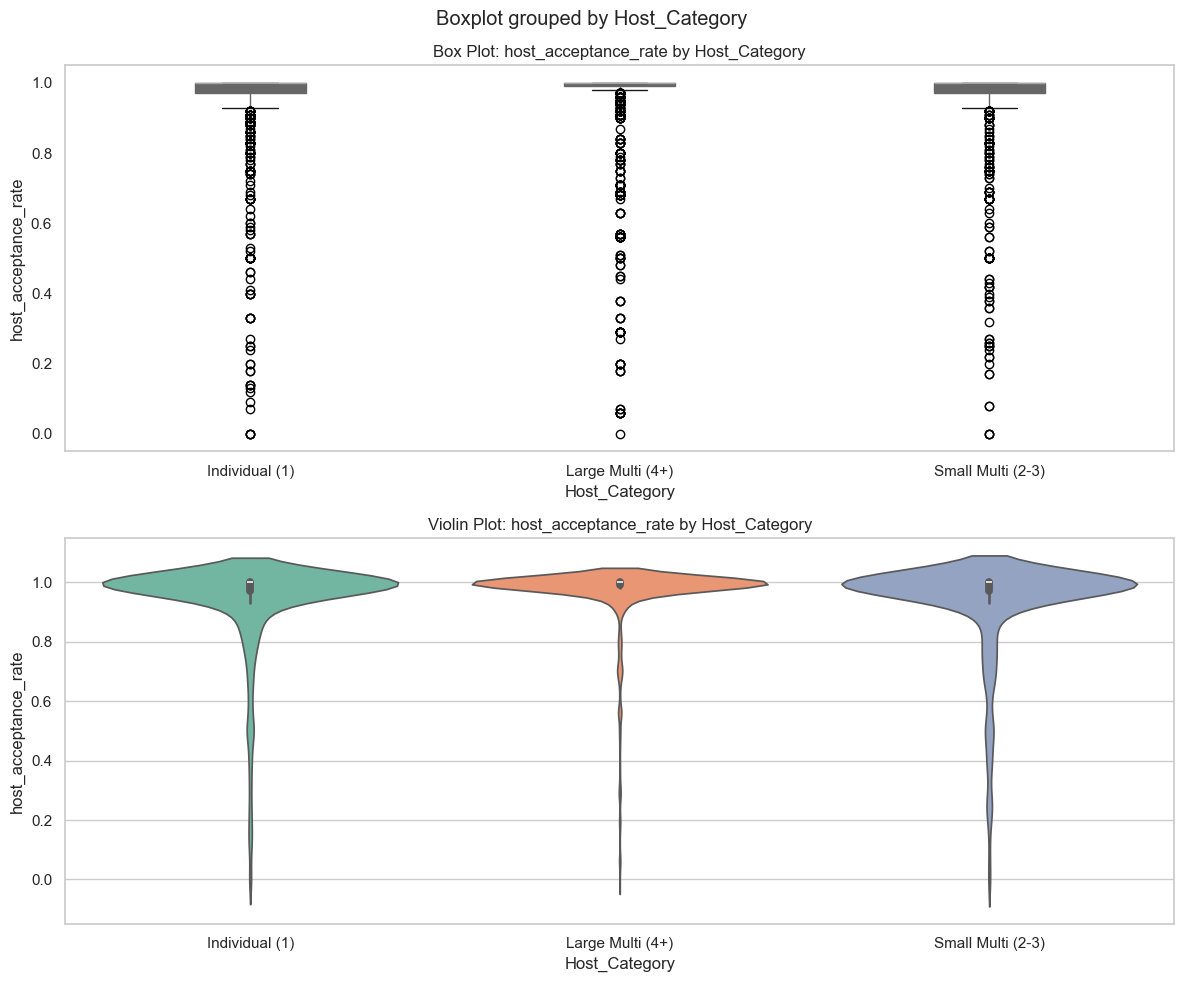

ONE-WAY ANOVA: host_acceptance_rate by Host_Category

Descriptive Statistics by Group:

  Host_Category = Individual (1):
    N:      911
    Mean:   0.9376
    Median: 1.0000
    Std:    0.1624
    Min:    0.0000
    Max:    1.0000

  Host_Category = Large Multi (4+):
    N:      2428
    Mean:   0.9671
    Median: 1.0000
    Std:    0.1165
    Min:    0.0000
    Max:    1.0000

  Host_Category = Small Multi (2-3):
    N:      754
    Mean:   0.9296
    Median: 1.0000
    Std:    0.1707
    Min:    0.0000
    Max:    1.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      28.7851
  P-value:             0.000000
  Eta-squared (η²):    0.014
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). Host_Category has a significant effect on host_acceptance_rate. Small effect (Eta-squared (η²) = 0.014).

Assumption Checks:
  Normality (Shapiro-Wilk test):
    Host_Category = Individual (1)

In [49]:
analyze_categorical_numerical(df_active["Host_Category"], df_active["host_acceptance_rate"])

**comment**
* multi hosts seem to be more willing to accept customers showing a more professional approach

**comment:**
* surprisingly the 2-3 category has the most superhosts (maybe a sign of hosts that want to put more effort in growing their rental business?)
* individuals have the lowest rate of superhosts but not far away from multihosts

### 8 - Availability 365

In [58]:
df["availability_365"].isnull().sum()

np.int64(0)

In [59]:
no_availability = df.loc[df["availability_365"]==0]
no_availability

,id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,...,instant_bookable,reviews_per_month,Host_Category,distance_to_center_km,distance_cat,price_cat,first_review_date,last_review_date,listing_age_years,market_maturity
11,PROP_FD5ADA,Lu - Enti - En #0011,HOST_CD8C05,2014-03-08,"Thessaloniki, Greece",None,None,NaN,False,3,...,True,0.05,Small Multi (2-3),8.54,Suburban (>6km),High (80-120€),2016-09-19,2021-07-04,8.76,Established (>8yr)
36,PROP_76A202,Pe - Enti - En #0009,HOST_C7818B,2014-12-26,"Thessaloniki, Greece",None,None,1.00,True,2,...,True,0.69,Small Multi (2-3),0.82,Downtown (<1km),NaN,2015-08-04,2024-11-08,9.89,Established (>8yr)
54,PROP_A75202,5* - Enti - En #0002,HOST_2C09DD,2015-06-10,"Makedonia Thraki, Greece",None,None,1.00,False,1,...,True,0.43,Individual (1),5.25,Neighborhoods (3-6km),NaN,2016-02-04,2024-11-15,9.39,Established (>8yr)
77,PROP_86C7A1,Εt - Enti - En #0024,HOST_8C9AB4,2013-03-25,"Thessaloniki, Greece",within a day,90%,0.98,True,9,...,False,0.91,Large Multi (4+),0.48,Downtown (<1km),NaN,2016-04-05,2024-10-31,9.22,Established (>8yr)
94,PROP_8F56BA,Te - Enti - En #0030,HOST_BE7ED6,2015-09-06,"Panorama, Greece",within a day,100%,1.00,True,1,...,False,1.35,Individual (1),1.55,Inner City (1-3km),NaN,2016-06-23,2025-06-13,9.00,Established (>8yr)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696,PROP_4EB532,Sa - Enti - En #2214,HOST_044261,2021-12-28,"Copenhagen, Denmark",within an hour,100%,0.99,False,609,...,True,NaN,Large Multi (4+),1.14,Inner City (1-3km),High (80-120€),NaT,NaT,NaN,NaN
3783,PROP_E6EB25,Sp - Enti - En #2277,HOST_B26BD6,2016-05-14,"Thessaloniki, Greece",None,None,1.00,True,4,...,True,0.65,Large Multi (4+),1.22,Inner City (1-3km),NaN,2024-12-23,2025-01-21,0.50,New (<2yr)
4022,PROP_677435,Su - Enti - En #2461,HOST_293619,2024-09-03,None,within an hour,83%,1.00,False,45,...,True,NaN,Large Multi (4+),1.70,Inner City (1-3km),Low (40-60€),NaT,NaT,NaN,NaN
4023,PROP_FE2E9C,St - Enti - En #2462,HOST_293619,2024-09-03,None,within an hour,83%,1.00,False,45,...,True,NaN,Large Multi (4+),1.52,Inner City (1-3km),Low (40-60€),NaT,NaT,NaN,NaN


159 listings with zero availability data. maybe a systematic error, faulty listings or inactive ones. they will be removed for validation purposes

In [62]:
df_bad = df.loc[df["first_review_date"].isnull()]
df_bad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 511 entries, 175 to 4621
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           511 non-null    object        
 1   name                         511 non-null    object        
 2   host_id                      511 non-null    object        
 3   host_since                   483 non-null    datetime64[ns]
 4   host_location                256 non-null    object        
 5   host_response_time           392 non-null    object        
 6   host_response_rate           392 non-null    object        
 7   host_acceptance_rate         414 non-null    float64       
 8   host_is_superhost            491 non-null    object        
 9   host_total_listings_count    483 non-null    Int16         
 10  host_identity_verified       483 non-null    object        
 11  neighbourhood                65 non-null     ob

In [63]:
df_bad.describe()

,host_since,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,distance_to_center_km,first_review_date,last_review_date,listing_age_years
count,483,414.00,483.00,511.00,511.00,511.00,511.00,510.00,511.00,511.00,...,0.00,0.00,0.00,0.00,0.00,0.00,511.00,0,0,0.00
mean,2020-07-20 04:31:18.260869632,0.88,88.12,40.63,22.95,3.46,1.05,1.27,1.73,73.58,...,NaN,NaN,NaN,NaN,NaN,NaN,1.73,NaT,NaT,NaN
min,2012-01-17 00:00:00,0.00,1.00,40.57,22.90,1.00,0.00,0.00,0.00,20.00,...,NaN,NaN,NaN,NaN,NaN,NaN,0.18,NaT,NaT,NaN
25%,2017-05-05 00:00:00,0.94,2.00,40.63,22.94,2.00,1.00,1.00,1.00,49.00,...,NaN,NaN,NaN,NaN,NaN,NaN,0.97,NaT,NaT,NaN
50%,2019-06-02 00:00:00,1.00,10.00,40.64,22.95,3.00,1.00,1.00,1.00,62.00,...,NaN,NaN,NaN,NaN,NaN,NaN,1.37,NaT,NaT,NaN
75%,2024-09-03 00:00:00,1.00,45.00,40.64,22.95,4.00,1.00,2.00,2.00,80.50,...,NaN,NaN,NaN,NaN,NaN,NaN,2.03,NaT,NaT,NaN
max,2025-06-20 00:00:00,1.00,"1,038.00",40.68,23.04,16.00,4.00,7.00,13.00,800.00,...,NaN,NaN,NaN,NaN,NaN,NaN,8.73,NaT,NaT,NaN
std,NaN,0.28,214.88,0.02,0.01,1.52,0.29,0.68,1.12,55.45,...,NaN,NaN,NaN,NaN,NaN,NaN,1.25,NaN,NaN,NaN


In [47]:
df_available = df.drop(index=no_availability.index)
df_available.shape

(4290, 43)

In [48]:
df_available[["availability_30", "availability_90", "availability_365"]].describe()

,availability_30,availability_90,availability_365
count,4290.00000,4290.000000,4290.000000
mean,17.20303,61.189744,243.851515
std,9.71926,25.481246,106.372674
min,0.00000,0.000000,1.000000
25%,9.00000,46.000000,162.000000
50%,19.00000,68.000000,266.000000
75%,26.00000,83.000000,343.000000
max,30.00000,90.000000,365.000000


In [49]:
for category in df_available["host_category"].unique():
    print(f"Host Category: {category}")
    mean = df_available.loc[df_available['host_category'] == category][["availability_30", "availability_90", "availability_365"]].dropna().mean()
    print(f"  Average Availability (days)")
    print(mean.round(2), "\n")

Host Category: Individual (1)
  Average Availability (days)
availability_30      15.32
availability_90      55.17
availability_365    226.43
dtype: float64 

Host Category: Large Multi (4+)
  Average Availability (days)
availability_30      18.42
availability_90      65.19
availability_365    256.59
dtype: float64 

Host Category: Small Multi (2-3)
  Average Availability (days)
availability_30      15.73
availability_90      56.20
availability_365    225.55
dtype: float64 



**comment**
* small multi and invidual listing host show similar availability patterns
* large multi seem to have more days of availability on average which indicates larger particiapation in the market

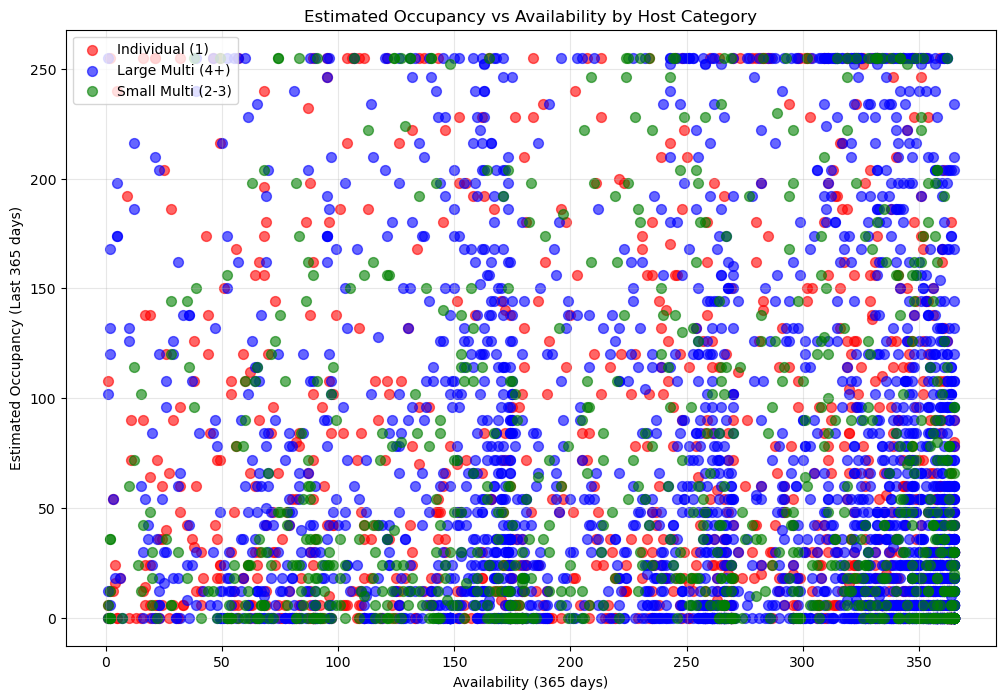

In [50]:
plt.figure(figsize=(12, 8))

# Create scatter plot with different colors for each host category
colors = ['red', 'blue', 'green']
for i, category in enumerate(df_available["host_category"].unique()):
    category_data = df_available[df_available['host_category'] == category]
    plt.scatter(category_data['availability_365'], category_data['estimated_occupancy_l365d'], 
                c=colors[i], alpha=0.6, label=category, s=50)

plt.xlabel('Availability (365 days)')
plt.ylabel('Estimated Occupancy (Last 365 days)')
plt.title('Estimated Occupancy vs Availability by Host Category')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

correlation analysis

In [64]:
# Correlation analysis by host category
for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    cat_data = df[df['Host_Category'] == category]
    
    # Key correlations
    corr_matrix = cat_data[['host_acceptance_rate', 'review_scores_rating', 
                             'estimated_revenue_l365d', 'estimated_occupancy_l365d',
                             'availability_365']].corr()
    
    print(f"\n{category} Correlations:")
    print(corr_matrix)


Individual (1) Correlations:
                           host_acceptance_rate  review_scores_rating  \
host_acceptance_rate                       1.00                  0.10   
review_scores_rating                       0.10                  1.00   
estimated_revenue_l365d                    0.24                  0.14   
estimated_occupancy_l365d                  0.26                  0.12   
availability_365                          -0.01                 -0.05   

                           estimated_revenue_l365d  estimated_occupancy_l365d  \
host_acceptance_rate                          0.24                       0.26   
review_scores_rating                          0.14                       0.12   
estimated_revenue_l365d                       1.00                       0.87   
estimated_occupancy_l365d                     0.87                       1.00   
availability_365                             -0.00                       0.01   

                           availability_365 

In [65]:
# Compare superhosts vs non-superhosts within each category
for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    cat_data = df[df['Host_Category'] == category]
    
    superhosts = cat_data[cat_data['host_is_superhost'] == True]
    non_superhosts = cat_data[cat_data['host_is_superhost'] == False]
    
    print(f"\n{category}:")
    print(f"Superhost avg revenue: {superhosts['estimated_revenue_l365d'].mean():.2f}")
    print(f"Non-superhost avg revenue: {non_superhosts['estimated_revenue_l365d'].mean():.2f}")
    print(f"Superhost avg rating: {superhosts['review_scores_rating'].mean():.2f}")
    print(f"Non-superhost avg rating: {non_superhosts['review_scores_rating'].mean():.2f}")


Individual (1):
Superhost avg revenue: 7631.87
Non-superhost avg revenue: 1998.03
Superhost avg rating: 4.91
Non-superhost avg rating: 4.79

Small Multi (2-3):
Superhost avg revenue: 6534.67
Non-superhost avg revenue: 1763.80
Superhost avg rating: 4.89
Non-superhost avg rating: 4.73

Large Multi (4+):
Superhost avg revenue: 5150.49
Non-superhost avg revenue: 2986.11
Superhost avg rating: 4.85
Non-superhost avg rating: 4.50


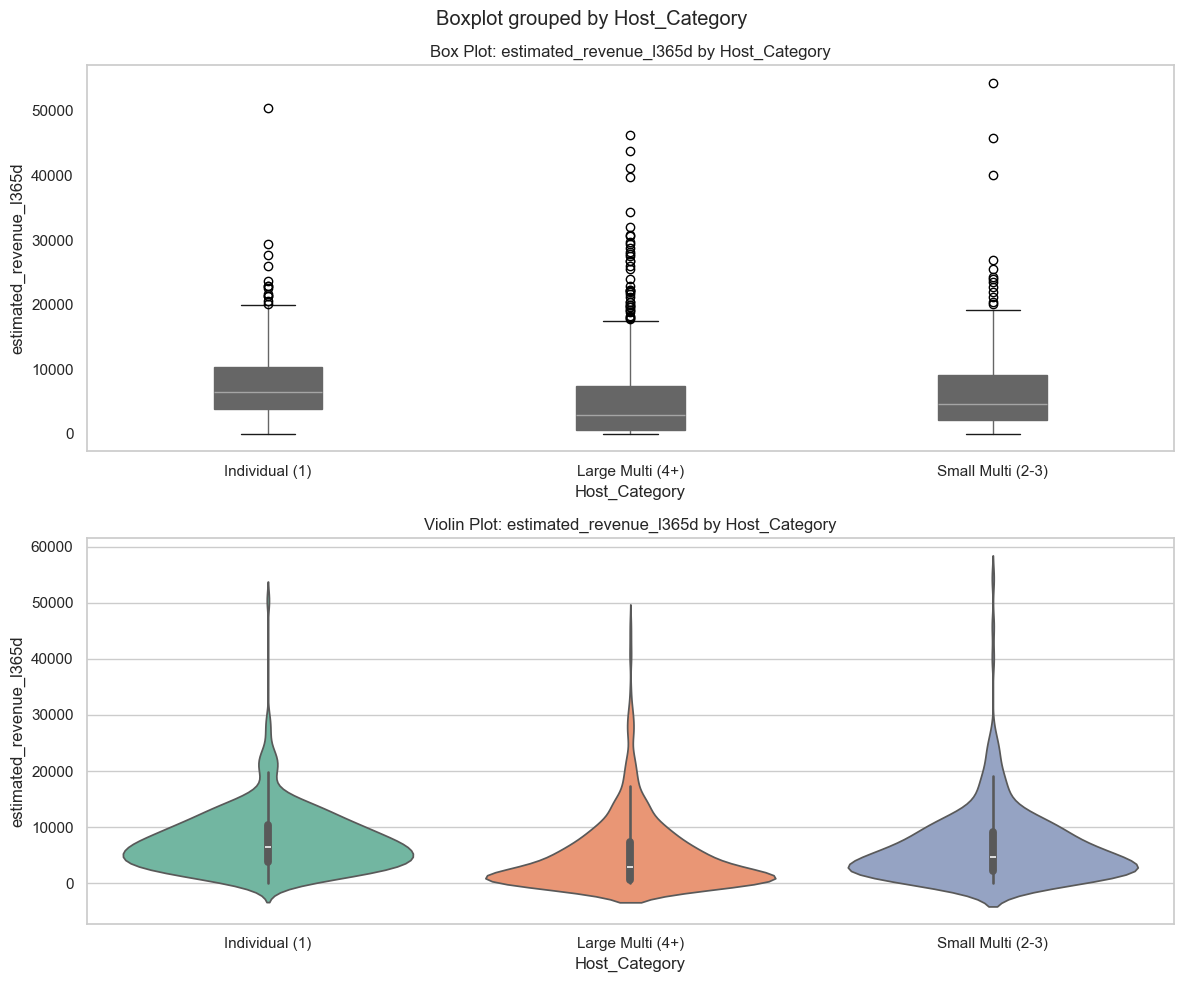

ONE-WAY ANOVA: estimated_revenue_l365d by Host_Category

Descriptive Statistics by Group:

  Host_Category = Individual (1):
    N:      371
    Mean:   7631.8733
    Median: 6552.0000
    Std:    5438.9986
    Min:    0.0000
    Max:    50430.0000

  Host_Category = Large Multi (4+):
    N:      805
    Mean:   5150.4944
    Median: 3000.0000
    Std:    6423.6059
    Min:    0.0000
    Max:    46320.0000

  Host_Category = Small Multi (2-3):
    N:      331
    Mean:   6534.6707
    Median: 4704.0000
    Std:    6542.5970
    Min:    0.0000
    Max:    54315.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      21.3941
  P-value:             0.000000
  Eta-squared (η²):    0.028
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). Host_Category has a significant effect on estimated_revenue_l365d. Small effect (Eta-squared (η²) = 0.028).

Assumption Checks:
  Normality (Shapiro-Wi

In [69]:
sh_df = df.loc[df["host_is_superhost"] == True]
analyze_categorical_numerical(sh_df["Host_Category"], sh_df["estimated_revenue_l365d"])

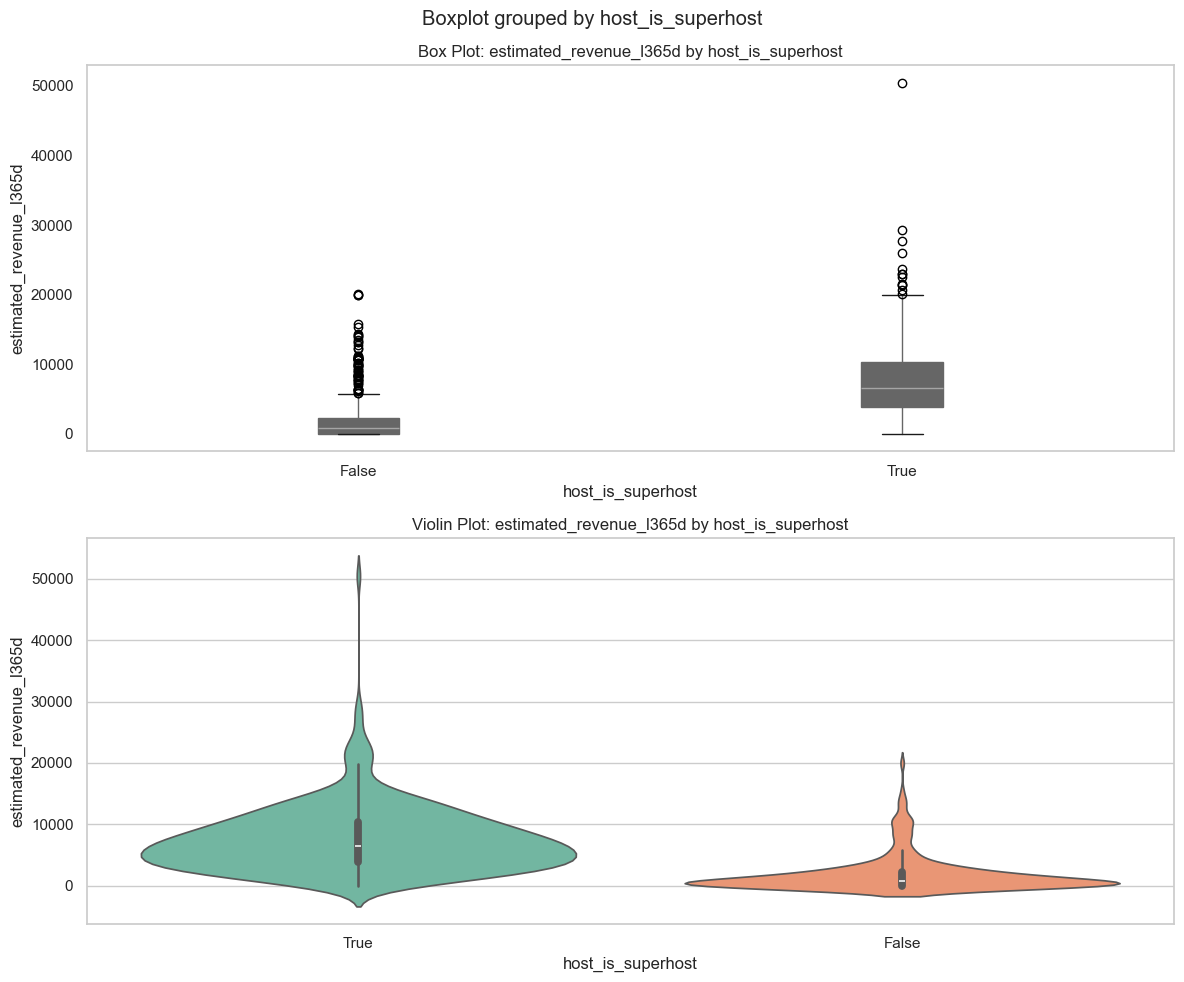

WELCH'S T-TEST: estimated_revenue_l365d by host_is_superhost

Descriptive Statistics by Group:

  host_is_superhost = True:
    N:      371
    Mean:   7631.8733
    Median: 6552.0000
    Std:    5438.9986
    Min:    0.0000
    Max:    50430.0000

  host_is_superhost = False:
    N:      681
    Mean:   1998.0279
    Median: 864.0000
    Std:    3100.2516
    Min:    0.0000
    Max:    20064.0000

Test Statistics:
  Test:                Welch's t-test
  Test statistic:      18.3901
  P-value:             0.000000
  Cohen's d:    1.381
  Effect size:         Large effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). host_is_superhost has a significant effect on estimated_revenue_l365d. Large effect (Cohen's d = 1.381).

Assumption Checks:
  Normality (Shapiro-Wilk test):
    host_is_superhost = True: p=0.0000 (Non-normal)
    host_is_superhost = False: p=0.0000 (Non-normal)
  Homogeneity of variance (Levene's test): p=0.0000 (Unequal vari

In [70]:
analyze_categorical_numerical(df.loc[df["Host_Category"] == "Individual (1)"]["host_is_superhost"], df["estimated_revenue_l365d"])

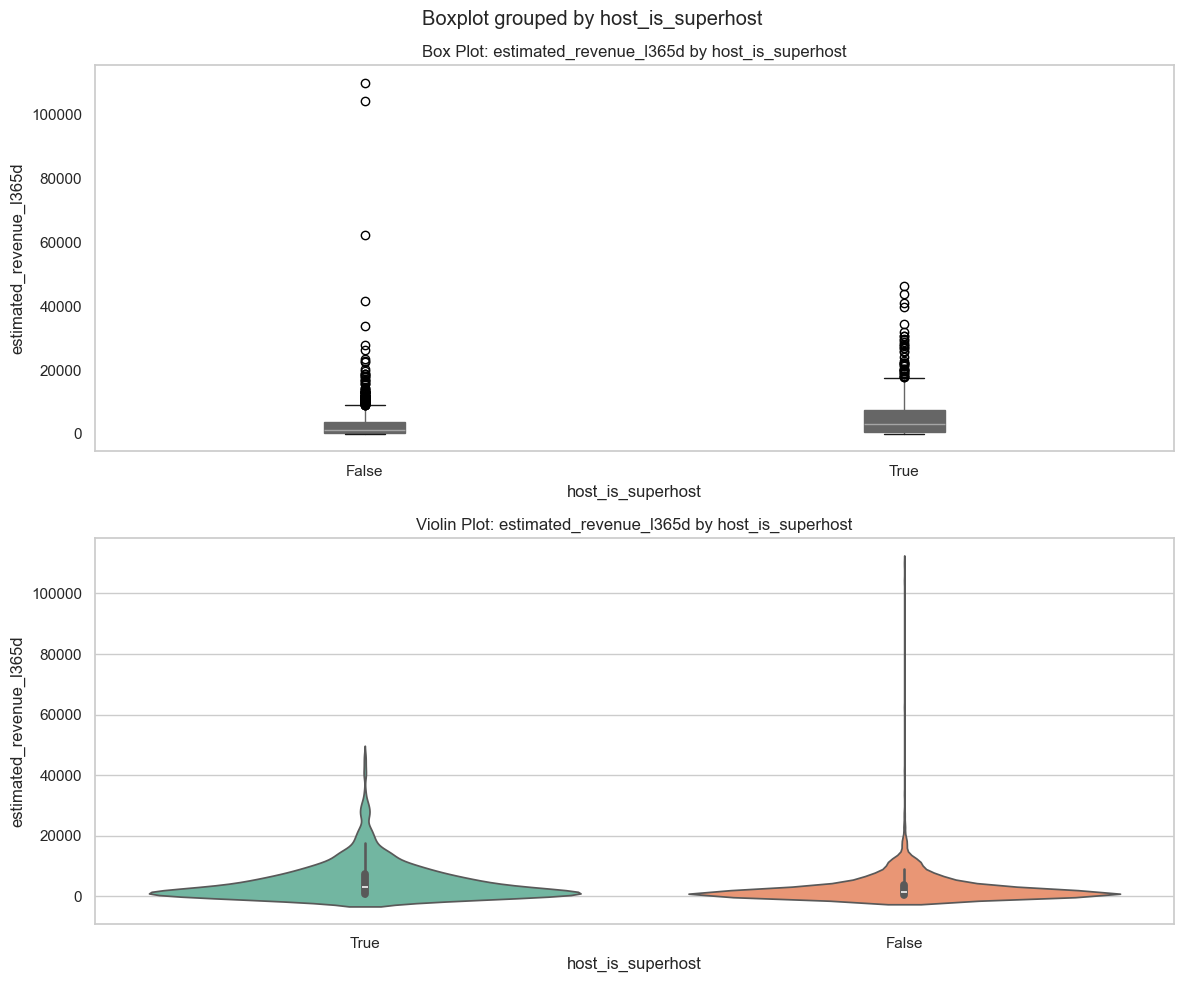

WELCH'S T-TEST: estimated_revenue_l365d by host_is_superhost

Descriptive Statistics by Group:

  host_is_superhost = True:
    N:      805
    Mean:   5150.4944
    Median: 3000.0000
    Std:    6423.6059
    Min:    0.0000
    Max:    46320.0000

  host_is_superhost = False:
    N:      1456
    Mean:   2986.1051
    Median: 1320.0000
    Std:    5705.6498
    Min:    0.0000
    Max:    109896.0000

Test Statistics:
  Test:                Welch's t-test
  Test statistic:      7.9771
  P-value:             0.000000
  Cohen's d:    0.362
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). host_is_superhost has a significant effect on estimated_revenue_l365d. Small effect (Cohen's d = 0.362).

Assumption Checks:
  Normality (Shapiro-Wilk test):
    host_is_superhost = True: p=0.0000 (Non-normal)
    host_is_superhost = False: p=0.0000 (Non-normal)
  Homogeneity of variance (Levene's test): p=0.0000 (Unequal va

In [71]:
analyze_categorical_numerical(df.loc[df["Host_Category"] == "Large Multi (4+)"]["host_is_superhost"], df["estimated_revenue_l365d"])

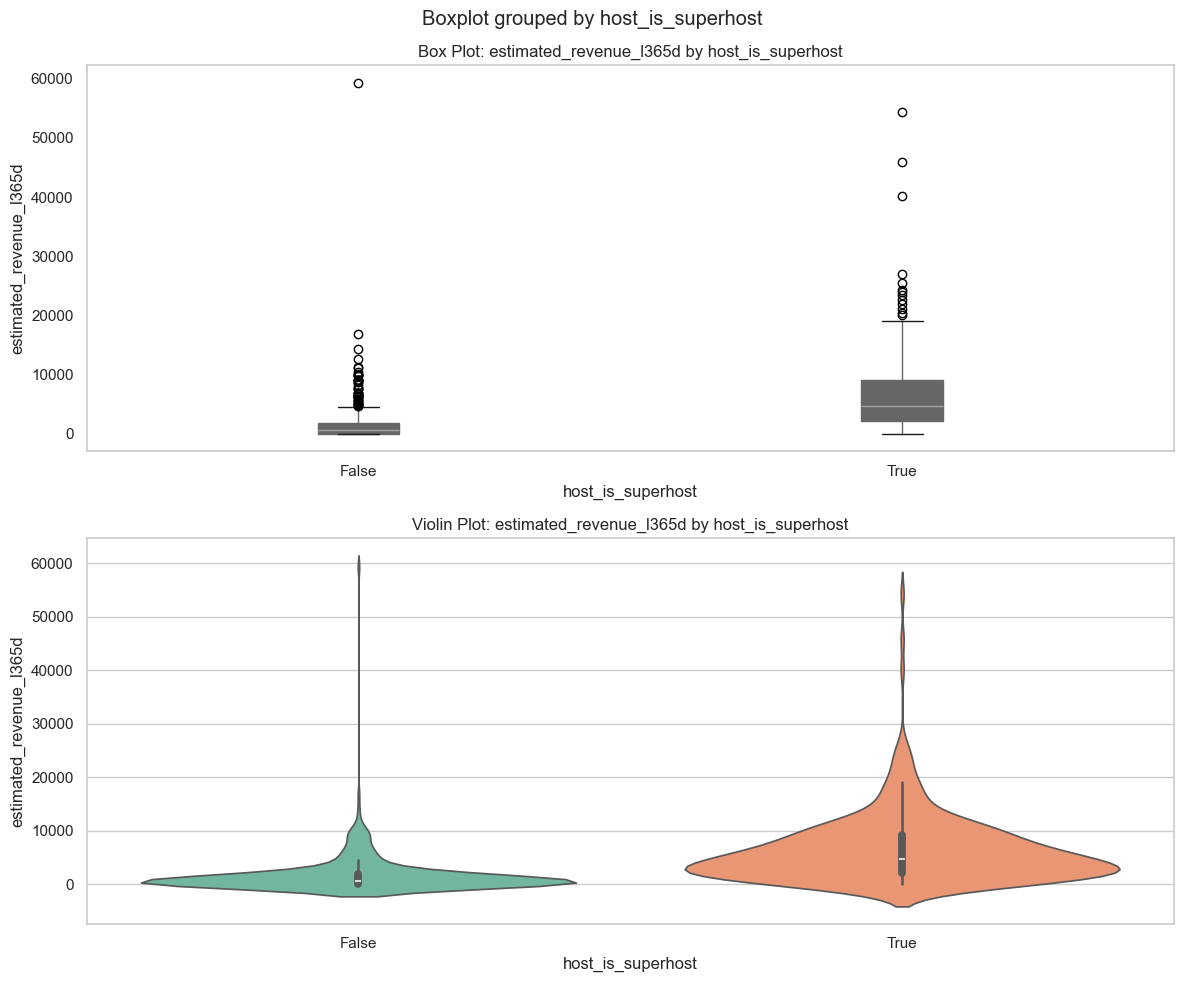

WELCH'S T-TEST: estimated_revenue_l365d by host_is_superhost

Descriptive Statistics by Group:

  host_is_superhost = False:
    N:      440
    Mean:   1763.7955
    Median: 684.0000
    Std:    3742.3798
    Min:    0.0000
    Max:    59280.0000

  host_is_superhost = True:
    N:      331
    Mean:   6534.6707
    Median: 4704.0000
    Std:    6542.5970
    Min:    0.0000
    Max:    54315.0000

Test Statistics:
  Test:                Welch's t-test
  Test statistic:      -11.8845
  P-value:             0.000000
  Cohen's d:    0.929
  Effect size:         Large effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). host_is_superhost has a significant effect on estimated_revenue_l365d. Large effect (Cohen's d = 0.929).

Assumption Checks:
  Normality (Shapiro-Wilk test):
    host_is_superhost = False: p=0.0000 (Non-normal)
    host_is_superhost = True: p=0.0000 (Non-normal)
  Homogeneity of variance (Levene's test): p=0.0000 (Unequal var

In [72]:
analyze_categorical_numerical(df.loc[df["Host_Category"] == "Small Multi (2-3)"]["host_is_superhost"], df["estimated_revenue_l365d"])

### statistical testing for base hypotheses

In [74]:
from scipy import stats
from scipy.stats import chi2_contingency

#### 1 - Revenue difference across groups and superhost status

#### 2 - Superhost revenue multiplier

In [75]:
print("\n" + "="*60)
print("TEST 2: SUPERHOST REVENUE PREMIUM (T-TESTS)")
print("="*60)

for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    superhosts = df[(df['Host_Category'] == category) & 
                    (df['host_is_superhost'] == True)]['estimated_revenue_l365d'].dropna()
    non_superhosts = df[(df['Host_Category'] == category) & 
                        (df['host_is_superhost'] == False)]['estimated_revenue_l365d'].dropna()
    
    t_stat, p_value = stats.ttest_ind(superhosts, non_superhosts)
    
    revenue_diff = superhosts.mean() - non_superhosts.mean()
    multiplier = superhosts.mean() / non_superhosts.mean() if non_superhosts.mean() > 0 else 0
    
    print(f"\n{category}:")
    print(f"  Revenue difference: €{revenue_diff:.2f} ({multiplier:.2f}x)")
    print(f"  t={t_stat:.3f}, p={p_value:.4f}, Significant: {p_value < 0.05}")


TEST 2: SUPERHOST REVENUE PREMIUM (T-TESTS)

Individual (1):
  Revenue difference: €5633.85 (3.82x)
  t=21.398, p=0.0000, Significant: True

Small Multi (2-3):
  Revenue difference: €4770.88 (3.70x)
  t=12.770, p=0.0000, Significant: True

Large Multi (4+):
  Revenue difference: €2164.39 (1.72x)
  t=8.253, p=0.0000, Significant: True


#### 4 - Review score diffences accross categories

In [85]:
print("\n" + "="*60)
print("TEST 3: REVIEW RATING DIFFERENCES ACROSS HOST TYPES")
print("="*60)

# Create aligned dataset - drop rows where either variable is NaN (same as analyze_categorical_numerical)
analysis_df = df[['Host_Category', 'review_scores_rating']].dropna()

rating_groups = []
for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    ratings = analysis_df[analysis_df['Host_Category'] == category]['review_scores_rating']
    rating_groups.append(ratings)
    print(f"{category}: mean={ratings.mean():.3f}, std={ratings.std():.3f}, n={len(ratings)}")

f_stat, p_value = stats.f_oneway(*rating_groups)
print(f"\nANOVA Results: F={f_stat:.3f}, p-value={p_value:.4f}")
print(f"Significant at α=0.05: {p_value < 0.05}")


TEST 3: REVIEW RATING DIFFERENCES ACROSS HOST TYPES
Individual (1): mean=4.840, std=0.281, n=998
Small Multi (2-3): mean=4.808, std=0.334, n=765
Large Multi (4+): mean=4.641, std=0.457, n=2348

ANOVA Results: F=109.178, p-value=0.0000
Significant at α=0.05: True


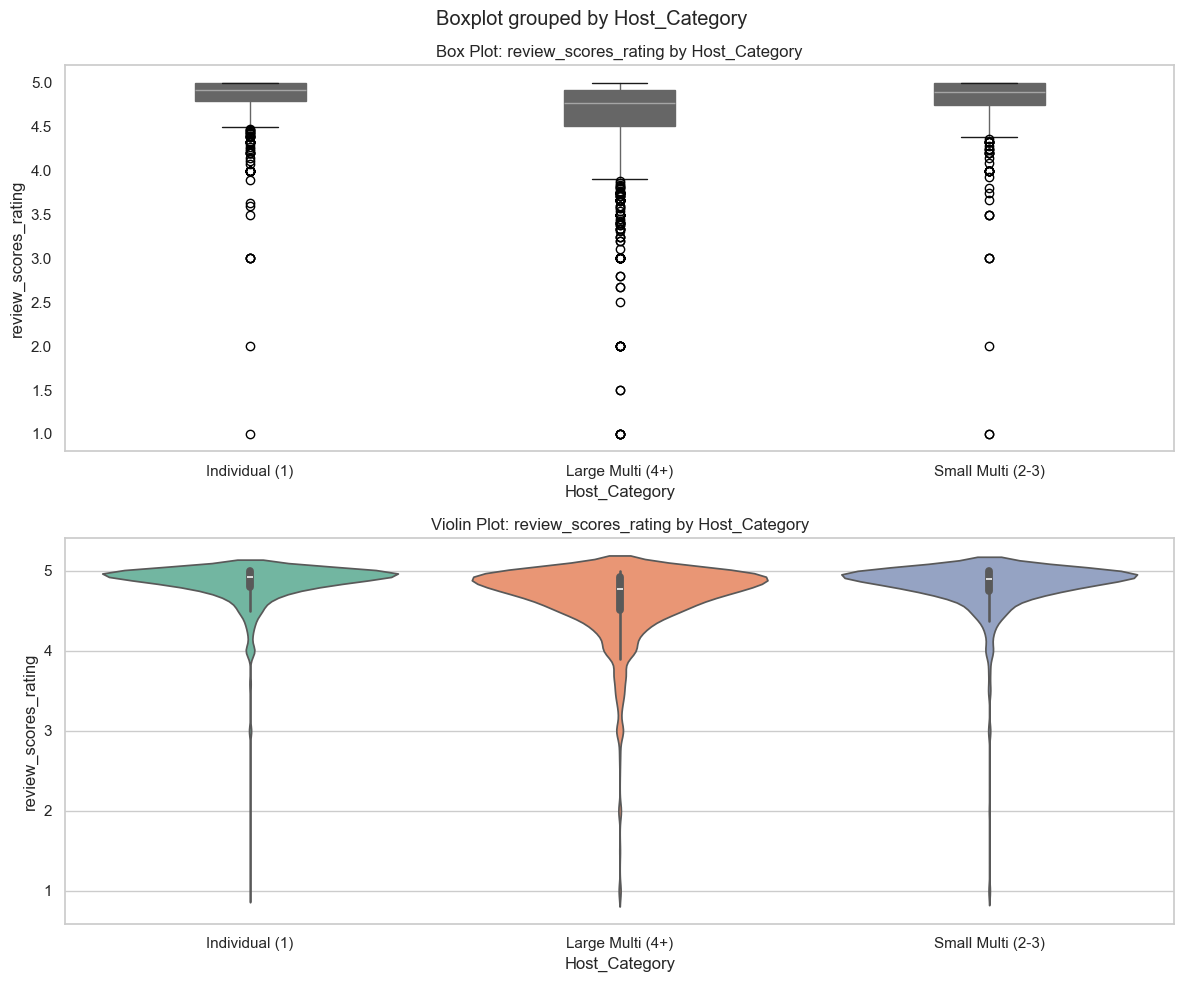

ONE-WAY ANOVA: review_scores_rating by Host_Category

Descriptive Statistics by Group:

  Host_Category = Individual (1):
    N:      998
    Mean:   4.8396
    Median: 4.9200
    Std:    0.2811
    Min:    1.0000
    Max:    5.0000

  Host_Category = Large Multi (4+):
    N:      2348
    Mean:   4.6411
    Median: 4.7700
    Std:    0.4571
    Min:    1.0000
    Max:    5.0000

  Host_Category = Small Multi (2-3):
    N:      765
    Mean:   4.8079
    Median: 4.9000
    Std:    0.3342
    Min:    1.0000
    Max:    5.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      109.1777
  P-value:             0.000000
  Eta-squared (η²):    0.050
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). Host_Category has a significant effect on review_scores_rating. Small effect (Eta-squared (η²) = 0.050).

Assumption Checks:
  Normality (Shapiro-Wilk test):
    Host_Category = Individual (1

In [86]:
analyze_categorical_numerical(df["Host_Category"], df["review_scores_rating"])

In [84]:
df.loc[df['Host_Category'] == "Individual (1)"]['review_scores_rating'].dropna().mean()

np.float64(4.839599198396794)

#### superhost rate differences

In [58]:
print("\n" + "="*60)
print("TEST 4: SUPERHOST RATE DIFFERENCES (CHI-SQUARE)")
print("="*60)

# Create contingency table
contingency_table = pd.crosstab(df['host_category'], df['host_is_superhost'])
print("\nContingency Table:")
print(contingency_table)

# Calculate percentages
superhost_rates = df.groupby('host_category')['host_is_superhost'].apply(
    lambda x: (x == True).sum() / len(x) * 100
)
print("\nSuperhost Rates:")
for category in superhost_rates.index:
    print(f"{category}: {superhost_rates[category]:.2f}%")

# Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square Results: χ²={chi2:.3f}, p-value={p_value:.4f}, df={dof}")
print(f"Significant at α=0.05: {p_value < 0.05}")


TEST 4: SUPERHOST RATE DIFFERENCES (CHI-SQUARE)

Contingency Table:
host_is_superhost  False  True 
host_category                  
Individual (1)       710    368
Large Multi (4+)    1437    830
Small Multi (2-3)    436    328

Superhost Rates:
Individual (1): 34.14%
Large Multi (4+): 32.20%
Small Multi (2-3): 41.36%

Chi-square Results: χ²=15.412, p-value=0.0005, df=2
Significant at α=0.05: True


#### effect size - should tests be trusted?

In [60]:

print("\n" + "="*60)
print("EFFECT SIZES (Cohen's d for revenue differences)")
print("="*60)

def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    superhosts = df[(df['host_category'] == category) & 
                    (df['host_is_superhost'] == True)]['estimated_revenue_l365d'].dropna()
    non_superhosts = df[(df['host_category'] == category) & 
                        (df['host_is_superhost'] == False)]['estimated_revenue_l365d'].dropna()
    
    if len(superhosts) > 0 and len(non_superhosts) > 0:
        d = cohens_d(superhosts, non_superhosts)
        interpretation = "small" if abs(d) < 0.5 else "medium" if abs(d) < 0.8 else "large"
        print(f"{category}: d={d:.3f} ({interpretation} effect)")


EFFECT SIZES (Cohen's d for revenue differences)
Individual (1): d=1.392 (large effect)
Small Multi (2-3): d=0.935 (large effect)
Large Multi (4+): d=0.369 (small effect)


In [62]:
null_super_multi =df.loc[(df["host_category"] == "Large Multi (4+)") & (df["host_is_superhost"].isnull())]

In [63]:
null_super_multi["estimated_revenue_l365d"].describe()

count      285.000000
mean      5409.600000
std       5576.249613
min          0.000000
25%       1302.000000
50%       3720.000000
75%       7812.000000
max      29574.000000
Name: estimated_revenue_l365d, dtype: float64